In [54]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import atomai as aoi
from sklearn import mixture

from utilities import load_images_from_folder, crop_image, intensity_clipping, get_coordinates, get_training_data

In [55]:
images = load_images_from_folder("processed data")

Processing images: 100%|███████████████████████| 13/13 [00:00<00:00, 276.83it/s]


In [56]:
expdata = images[0]
training_data, training_coordinates = get_training_data(expdata,32)
training_coordinates[:,[1,0]] = training_coordinates[:,[0,1]]
d0, d1, d2 = training_data.shape

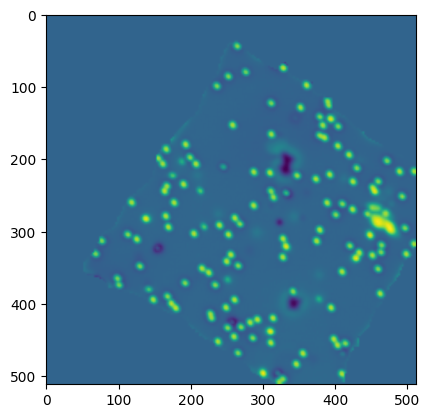

In [57]:
plt.imshow(expdata)

In [58]:
class_1_counts = []
class_2_counts = []

for i in range(0,100,1):
    window_size = 32
    n_components = 2
    covariance = 'diag'
    random_state = i
    clf = mixture.GaussianMixture(
        n_components = n_components,
        covariance_type = covariance,
        random_state = random_state)
    X_vec = training_data.reshape(d0,d1*d2)
    classes = clf.fit_predict(X_vec) +1
    cla = np.ndarray(shape=(
        np.amax(classes), int(window_size), int(window_size)))

    cl_all = []
    for i in range(np.amax(classes)):
        cl = training_data[classes == i + 1]
        cl_all.append(cl)
        cla[i] = np.mean(cl, axis=0)

    class_1_counts.append(len(cl_all[0]))
    class_2_counts.append(len(cl_all[1]))

class_1_counts = np.array(class_1_counts)
class_2_counts = np.array(class_2_counts)
possible_distributions = np.concatenate((class_1_counts,class_2_counts))

In [59]:
most_frequent_distribution = np.bincount(possible_distributions).argmax()
if most_frequent_distribution in class_1_counts:
    random_state_choice = np.where(class_1_counts == most_frequent_distribution)[0][0]
else:
    random_state_choice = np.where(class_2_counts == most_frequent_distribution)[0][0]


GMM components


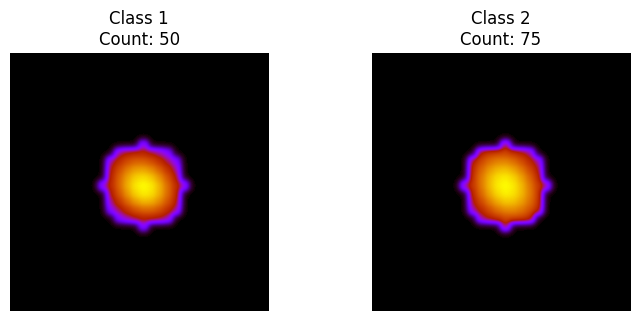

In [60]:
window_size = 32
n_components = 2
covariance = 'diag'
random_state = random_state_choice
clf = mixture.GaussianMixture(
    n_components = n_components,
    covariance_type = covariance,
    random_state = random_state)
X_vec = training_data.reshape(d0,d1*d2)
classes = clf.fit_predict(X_vec) +1
cla = np.ndarray(shape=(
    np.amax(classes), int(window_size), int(window_size)))

rows = int(np.ceil(float(n_components)/5))
cols = int(np.ceil(float(np.amax(classes))/rows))
fig = plt.figure(figsize=(4*cols, 4*(1+rows//2)))
gs = gridspec.GridSpec(rows, cols)
print('\nGMM components')

cl_all = []
for i in range(np.amax(classes)):
    cl = training_data[classes == i + 1]
    cl_all.append(cl)
    cla[i] = np.mean(cl, axis=0)
    ax = fig.add_subplot(gs[i])
    ax.imshow(cla[i, :, :], cmap='gnuplot',
            interpolation='Gaussian')
    ax.axis('off')
    ax.set_title('Class '+str(i+1)+'\nCount: '+str(len(cl)))

plt.subplots_adjust(hspace=0.6, wspace=0.4)
plt.show()

In [61]:
probs = clf.predict_proba(X_vec)

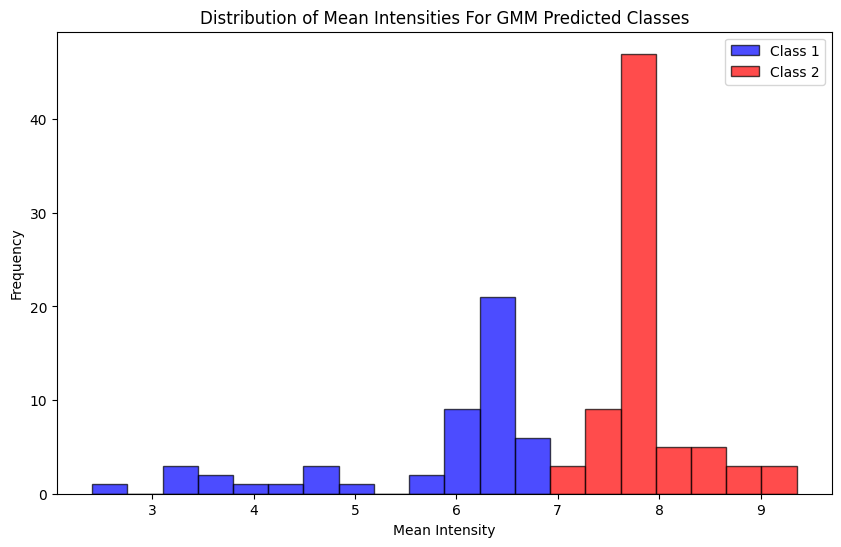

In [113]:
class_labels = np.unique(classes)

class_1_indices = np.where(classes == class_labels[0])
class_2_indices = np.where(classes == class_labels[1])

class_1_average_intensities = np.mean(training_data[class_1_indices], axis = (1,2))
class_2_average_intensities = np.mean(training_data[class_2_indices], axis = (1,2))

all_intensities = np.concatenate([class_1_average_intensities, class_2_average_intensities])
bins = np.histogram_bin_edges(all_intensities, bins=20)

plt.figure(figsize=(10, 6))
plt.hist(class_1_average_intensities, bins=bins, alpha=0.7, label='Class 1', color='blue', edgecolor='black')
plt.hist(class_2_average_intensities, bins=bins, alpha=0.7, label='Class 2', color='red', edgecolor='black')
plt.title('Distribution of Mean Intensities For GMM Predicted Classes')
plt.xlabel('Mean Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

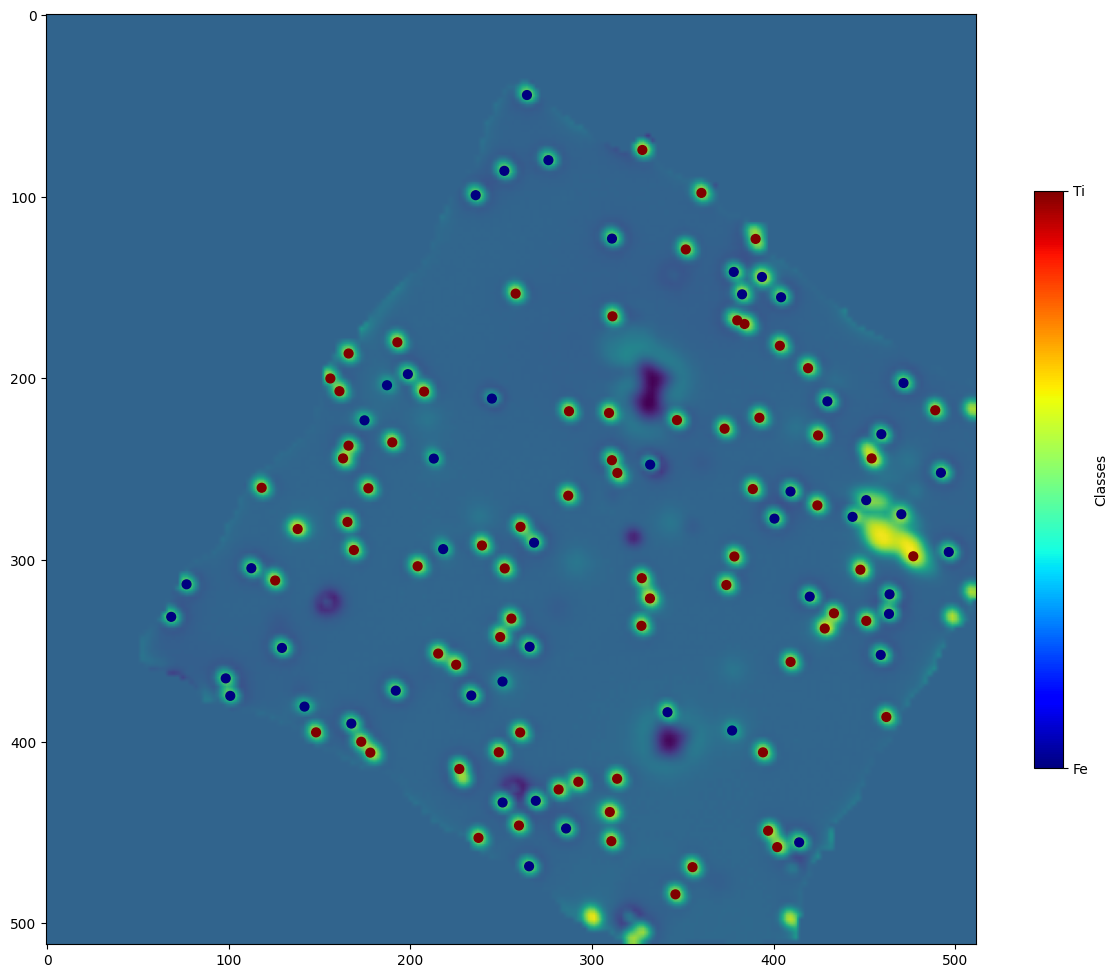

In [63]:
atom_classes = classes.astype(object)
if np.min(class_1_average_intensities) < np.min(class_2_average_intensities):
    atom_classes[atom_classes == 1] = "Fe"
    atom_classes[atom_classes == 2] = "Ti"

else:
    atom_classes[atom_classes == 2] = "Fe"
    atom_classes[atom_classes == 1] = "Ti"

class_labels, class_numeric = np.unique(atom_classes, return_inverse=True)

plt.figure(figsize=(15, 15))
sc = plt.scatter(training_coordinates[:, 0], training_coordinates[:, 1], c=class_numeric, s=40,
            cmap="jet")
im = plt.imshow(expdata)
cbar = plt.colorbar(sc, shrink=0.5, label="Classes")
cbar.set_ticks(np.arange(len(class_labels)))
cbar.set_ticklabels(class_labels)
#for i, coord in enumerate(training_coordinates):
#    plt.text(coord[0], coord[1], f'({coord[0]:.2f}, {coord[1]:.2f})', fontsize=8, color='black')
plt.show()

In [118]:
Fe_indices = np.where(class_numeric == 0)[0]
Ti_indices = np.where(class_numeric == 1)[0]

Fe_data = training_data[Fe_indices]
Ti_data = training_data[Ti_indices]

Fe_coordinates = training_coordinates[Fe_indices]
Ti_coordinates = training_coordinates[Ti_indices]

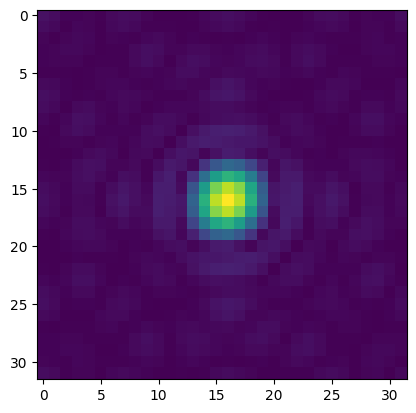

In [119]:
fourier_transformed_fe = np.fft.fft2(Fe_data, axes=(1, 2))
magnitude_fe = np.abs(fourier_transformed_fe)
shifted_fe = np.fft.fftshift(magnitude_fe, axes=(1, 2))
mapped_array_fe = np.zeros_like(Fe_data, dtype=np.float64)
mapped_array_fe[:, :32, :32] = shifted_fe
a, b, c = mapped_array_fe.shape
plt.imshow(mapped_array_fe[0])

In [120]:
fe_class_1_counts = []
fe_class_2_counts = []

for i in range(0,100,1):
    window_size = 32
    n_components = 2
    covariance = 'diag'
    random_state = i
    fe_ft_clf = mixture.GaussianMixture(
        n_components = n_components,
        covariance_type = covariance,
        random_state = random_state)
    X_vec_Fe = mapped_array_fe.reshape(a, b*c)
    fe_ft_classes = fe_ft_clf.fit_predict(X_vec_Fe) +1
    fe_ft_cla = np.ndarray(shape=(
        np.amax(fe_ft_classes), int(window_size), int(window_size)))

    fe_ft_cl_all = []
    for i in range(np.amax(fe_ft_classes)):
        fe_ft_cl = mapped_array_fe[fe_ft_classes == i + 1]
        fe_ft_cl_all.append(fe_ft_cl)
        fe_ft_cla[i] = np.mean(fe_ft_cl, axis=0)

    fe_class_1_counts.append(len(fe_ft_cl_all[0]))
    fe_class_2_counts.append(len(fe_ft_cl_all[1]))

fe_class_1_counts = np.array(fe_class_1_counts)
fe_class_2_counts = np.array(fe_class_2_counts)
fe_possible_distributions = np.concatenate((fe_class_1_counts,fe_class_2_counts))

In [121]:
fe_most_frequent_distribution = np.bincount(fe_possible_distributions).argmax()
if fe_most_frequent_distribution in fe_class_1_counts:
    fe_random_state_choice = np.where(fe_class_1_counts == fe_most_frequent_distribution)[0][0]
else:
    fe_random_state_choice = np.where(fe_class_2_counts == fe_most_frequent_distribution)[0][0]


GMM components


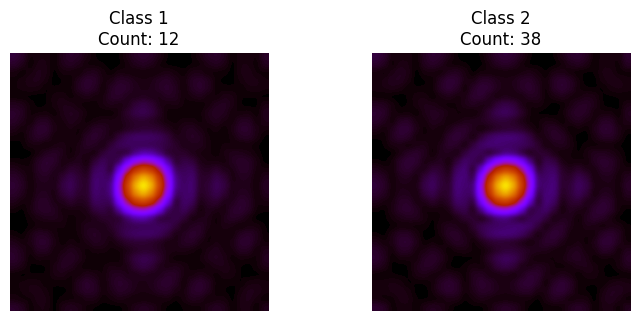

In [122]:
window_size = 32
n_components = 2
covariance = 'diag'
random_state = fe_random_state_choice
fe_ft_clf = mixture.GaussianMixture(
    n_components = n_components,
    covariance_type = covariance,
    random_state = random_state)
X_vec_Fe = mapped_array_fe.reshape(a, b*c)
fe_ft_classes = fe_ft_clf.fit_predict(X_vec_Fe) +1
fe_ft_cla = np.ndarray(shape=(
    np.amax(fe_ft_classes), int(window_size), int(window_size)))

rows = int(np.ceil(float(n_components)/5))
cols = int(np.ceil(float(np.amax(fe_ft_classes))/rows))
fig = plt.figure(figsize=(4*cols, 4*(1+rows//2)))
gs = gridspec.GridSpec(rows, cols)
print('\nGMM components')

fe_ft_cl_all = []
for i in range(np.amax(fe_ft_classes)):
    fe_ft_cl = mapped_array_fe[fe_ft_classes == i + 1]
    fe_ft_cl_all.append(fe_ft_cl)
    fe_ft_cla[i] = np.mean(fe_ft_cl, axis=0)
    ax = fig.add_subplot(gs[i])
    ax.imshow(fe_ft_cla[i, :, :], cmap='gnuplot',
            interpolation='Gaussian')
    ax.axis('off')
    ax.set_title('Class '+str(i+1)+'\nCount: '+str(len(fe_ft_cl)))

plt.subplots_adjust(hspace=0.6, wspace=0.4)
plt.show()

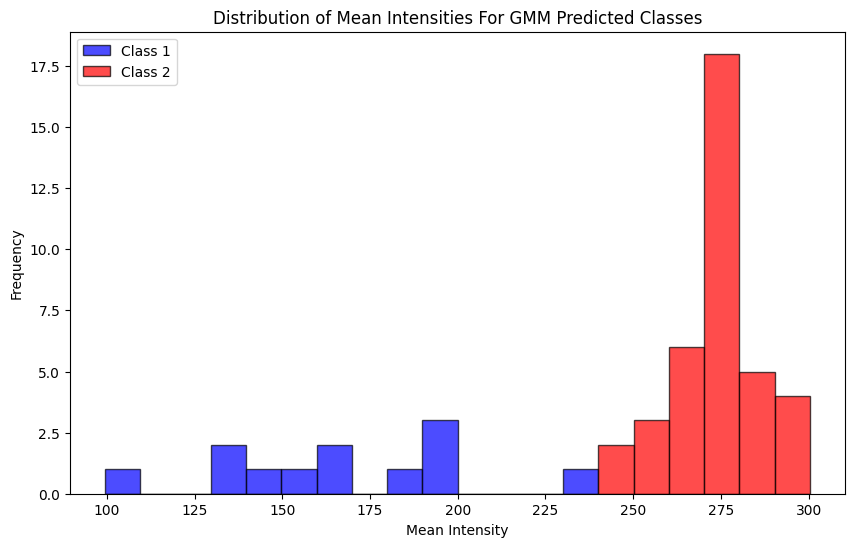

In [123]:
fe_class_labels = np.unique(fe_ft_classes)

fe_class_1_indices = np.where(fe_ft_classes == fe_class_labels[0])
fe_class_2_indices = np.where(fe_ft_classes == fe_class_labels[1])

fe_class_1_average_intensities = np.mean(mapped_array_fe[fe_class_1_indices], axis = (1,2))
fe_class_2_average_intensities = np.mean(mapped_array_fe[fe_class_2_indices], axis = (1,2))

fe_all_intensities = np.concatenate([fe_class_1_average_intensities, fe_class_2_average_intensities])
bins = np.histogram_bin_edges(fe_all_intensities, bins=20)

plt.figure(figsize=(10, 6))
plt.hist(fe_class_1_average_intensities, bins=bins, alpha=0.7, label='Class 1', color='blue', edgecolor='black')
plt.hist(fe_class_2_average_intensities, bins=bins, alpha=0.7, label='Class 2', color='red', edgecolor='black')
plt.title('Distribution of Mean Intensities For GMM Predicted Classes')
plt.xlabel('Mean Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

27.255712541810215
(32, 32)


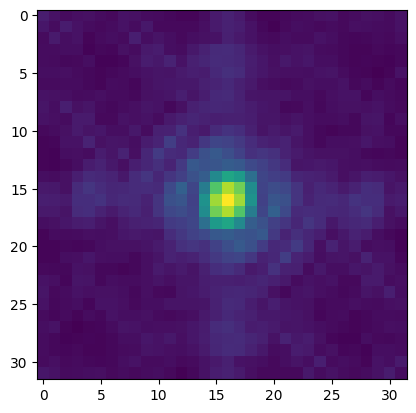

In [225]:
print(np.mean(np.std(mapped_array_fe[fe_class_2_indices], axis =0)))
print(np.std(mapped_array_fe[fe_class_2_indices], axis =0).shape)
plt.imshow(np.std(mapped_array_fe[fe_class_2_indices], axis=0))

Text(0.95, 0.05, '\nx : 16.0\ny : 16.0\nwidth_x : 5.7\nwidth_y : 5.9')

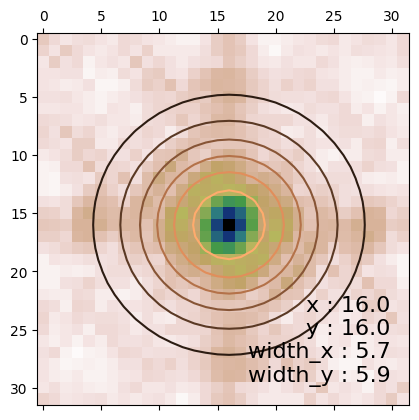

In [229]:
plt.matshow(np.std(mapped_array_fe[fe_class_2_indices], axis =0), cmap=plt.cm.gist_earth_r)
params = fitgaussian(np.std(mapped_array_fe[fe_class_2_indices], axis =0))
fit = gaussian(*params)

plt.contour(fit(*np.indices(np.std(mapped_array_fe[fe_class_2_indices], axis =0).shape)), cmap=plt.cm.copper)
ax = plt.gca()
(height, x, y, width_x, width_y) = params
plt.text(0.95, 0.05, """
x : %.1f
y : %.1f
width_x : %.1f
width_y : %.1f""" %(x, y, width_x, width_y),
        fontsize=16, horizontalalignment='right',
        verticalalignment='bottom', transform=ax.transAxes)

Text(0.95, 0.05, '\nx : 16.0\ny : 16.0\nwidth_x : 2.4\nwidth_y : 2.2')

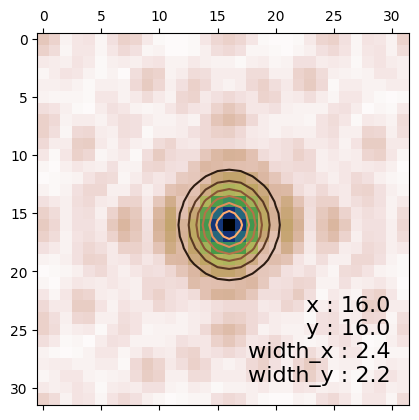

In [230]:
plt.matshow(np.std(mapped_array_fe[fe_class_1_indices], axis =0), cmap=plt.cm.gist_earth_r)
params = fitgaussian(np.std(mapped_array_fe[fe_class_1_indices], axis =0))
fit = gaussian(*params)

plt.contour(fit(*np.indices(np.std(mapped_array_fe[fe_class_1_indices], axis =0).shape)), cmap=plt.cm.copper)
ax = plt.gca()
(height, x, y, width_x, width_y) = params
plt.text(0.95, 0.05, """
x : %.1f
y : %.1f
width_x : %.1f
width_y : %.1f""" %(x, y, width_x, width_y),
        fontsize=16, horizontalalignment='right',
        verticalalignment='bottom', transform=ax.transAxes)

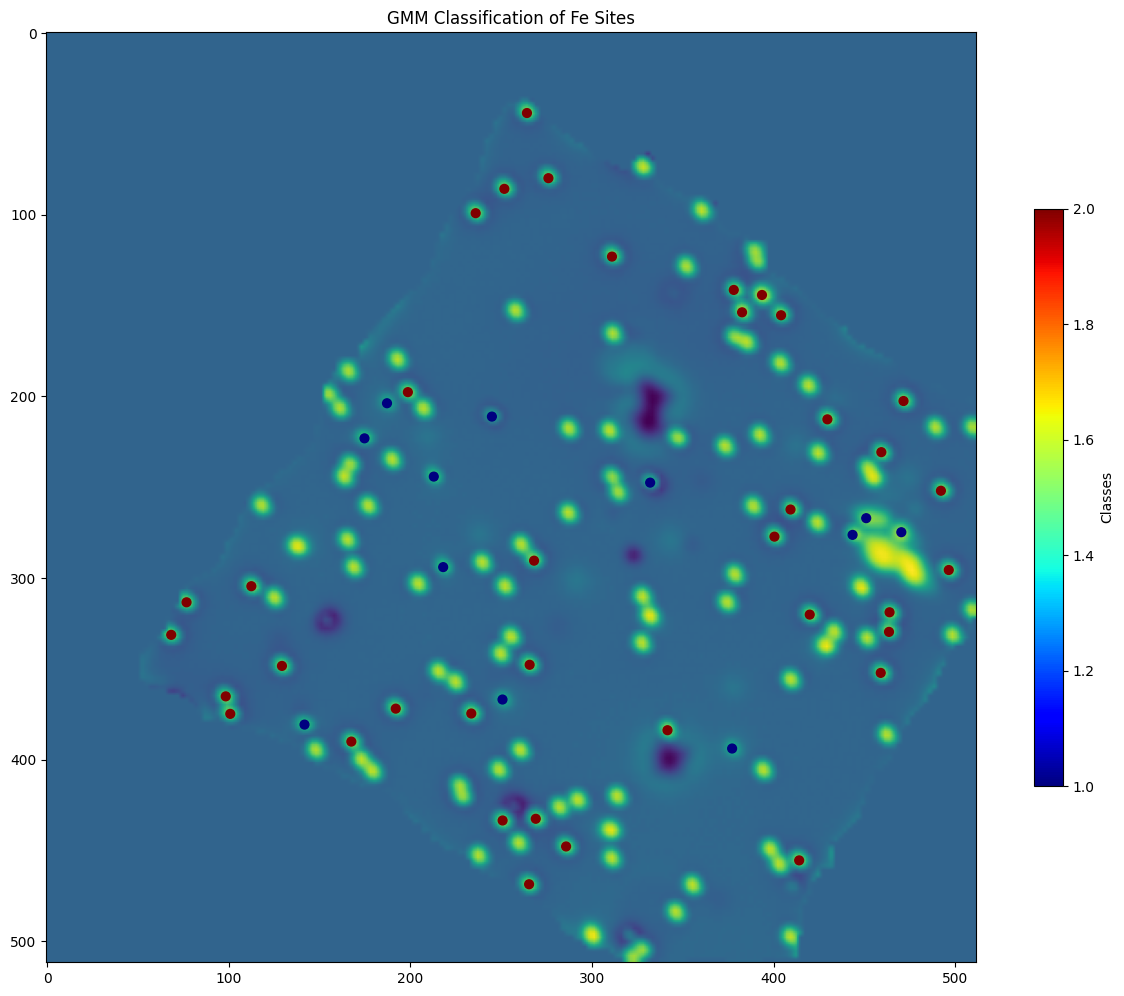

In [124]:
plt.figure(figsize=(15, 15))
sc = plt.scatter(Fe_coordinates[:, 0], Fe_coordinates[:, 1], c=fe_ft_classes, s=40,
            cmap="jet")
im = plt.imshow(expdata)
cbar = plt.colorbar(sc, shrink=0.5, label="Classes")
plt.title('GMM Classification of Fe Sites')
plt.show()

Text(0, 0.5, 'explained variance (percent)')

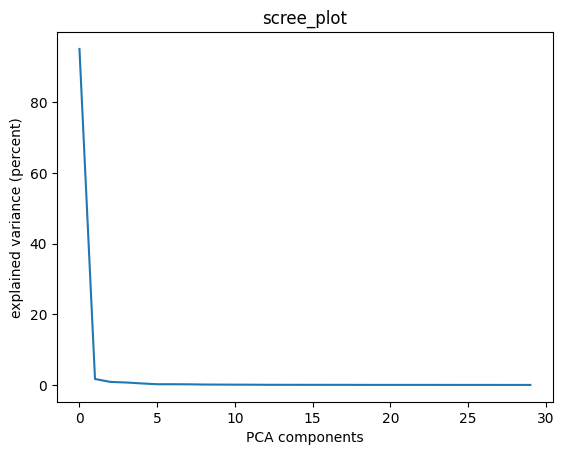

In [125]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 30)
pca_load = pca.fit_transform(X_vec_Fe)
pca_components = pca.components_

plt.plot(np.arange(30), pca.explained_variance_ratio_*100)
plt.title('scree_plot')
plt.xlabel('PCA components')
plt.ylabel('explained variance (percent)')

Loading Maps


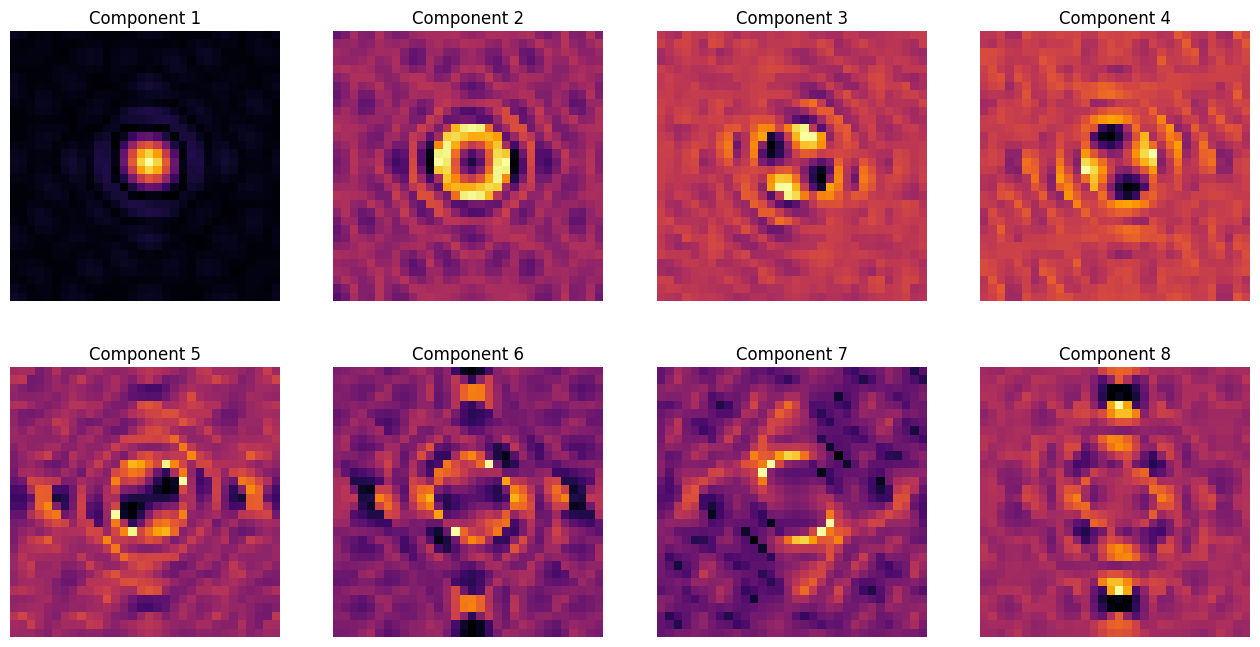

In [126]:
print('Loading Maps')
rows, cols = 2, 4
gs2 = gridspec.GridSpec(rows, cols)
fig2 = plt.figure(figsize = (4*cols, 4*(1+rows//1.5)))
for i in range(8):
    ax2 = fig2.add_subplot(gs2[i])
    ax2.imshow(pca_components[i,:].reshape(window_size, window_size), cmap = 'inferno', origin = 'lower')
    ax2.set_title('Component ' + str(i+1))
    plt.tick_params(labelsize = 18)
    plt.axis('off')
plt.show()

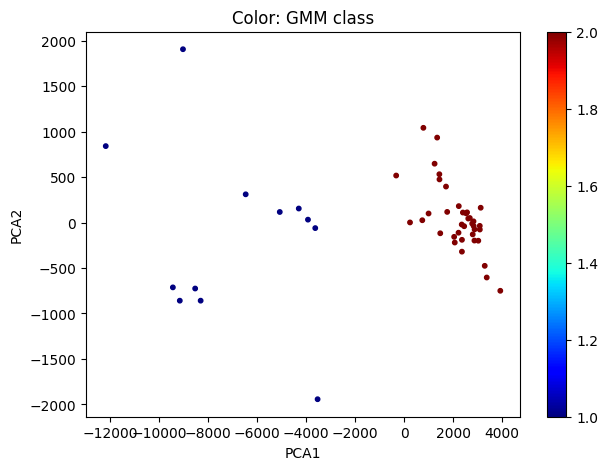

In [127]:
fig, ax = plt.subplots(figsize = (7,5))
scatter_plot = ax.scatter(pca_load[:,0], pca_load[:,1], c = fe_ft_classes, cmap = 'jet', s = 10)
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_title('Color: GMM class')
plt.colorbar(scatter_plot, ax=ax)

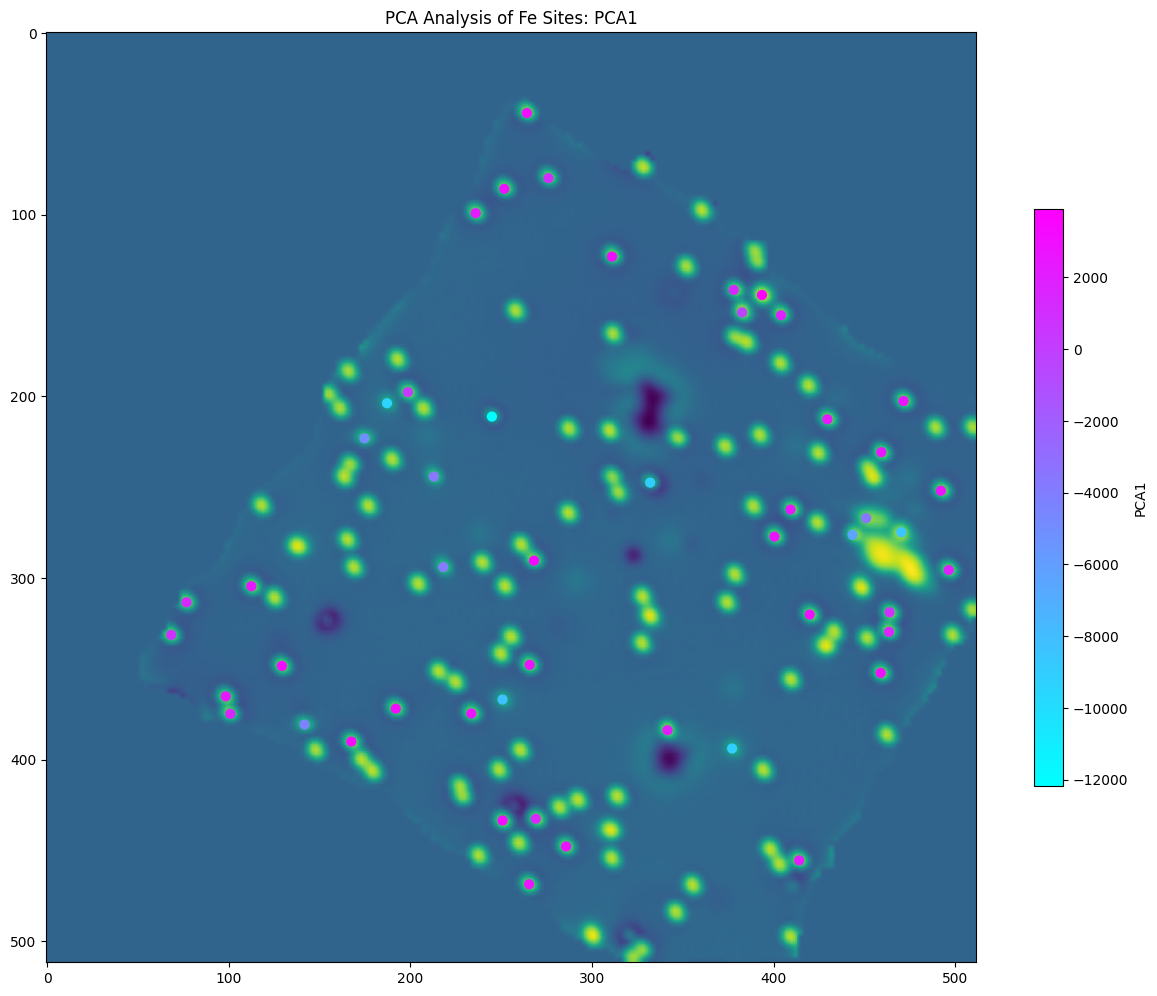

In [128]:
plt.figure(figsize=(15, 15))
sc = plt.scatter(Fe_coordinates[:, 0], Fe_coordinates[:, 1], c=pca_load[:,0], s=40,
            cmap="cool")
im = plt.imshow(expdata)
cbar = plt.colorbar(sc, shrink=0.5, label="PCA1")
plt.title("PCA Analysis of Fe Sites: PCA1")
plt.show()

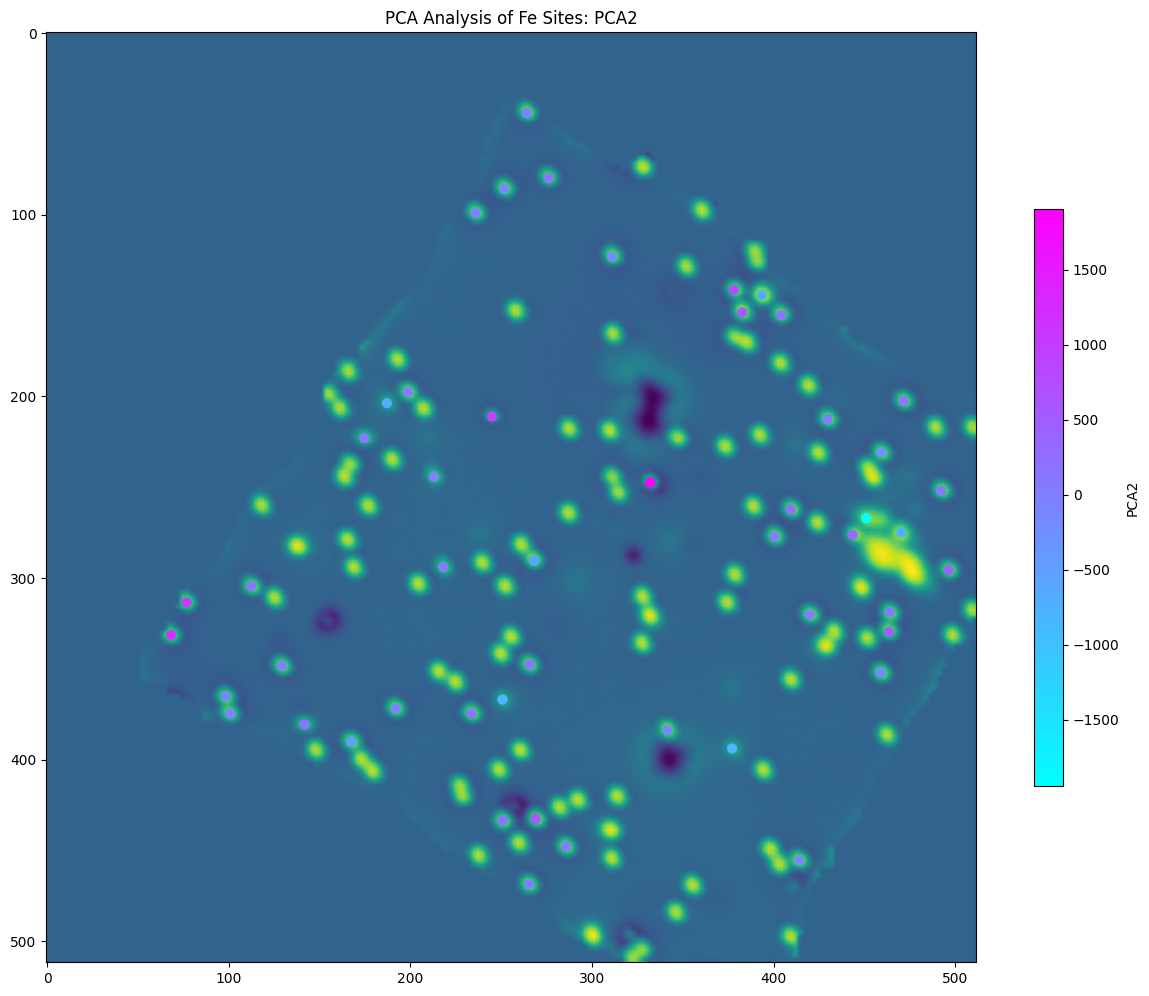

In [129]:
plt.figure(figsize=(15, 15))
sc = plt.scatter(Fe_coordinates[:, 0], Fe_coordinates[:, 1], c=pca_load[:,1], s=40,
            cmap="cool")
im = plt.imshow(expdata)
cbar = plt.colorbar(sc, shrink=0.5, label="PCA2")
plt.title("PCA Analysis of Fe Sites: PCA2")
plt.show()

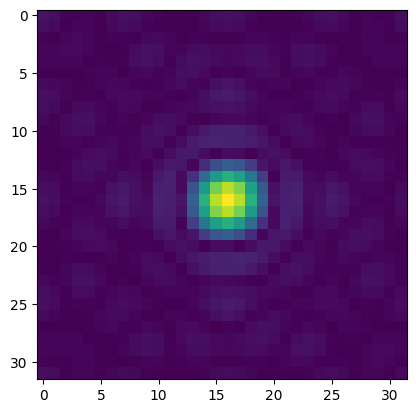

In [130]:
fourier_transformed_ti = np.fft.fft2(Ti_data, axes=(1, 2))
magnitude_ti = np.abs(fourier_transformed_ti)
shifted_ti = np.fft.fftshift(magnitude_ti, axes=(1, 2))
mapped_array_ti = np.zeros_like(Ti_data, dtype=np.float64)
mapped_array_ti[:, :32, :32] = shifted_ti
a, b, c = mapped_array_ti.shape
plt.imshow(mapped_array_ti[15])

In [77]:
ti_class_1_counts = []
ti_class_2_counts = []

for i in range(0,100,1):
    window_size = 32
    n_components = 2
    covariance = 'diag'
    random_state = i
    ti_ft_clf = mixture.GaussianMixture(
        n_components = n_components,
        covariance_type = covariance,
        random_state = random_state)
    X_vec_Ti = mapped_array_ti.reshape(a, b*c)
    ti_ft_classes = ti_ft_clf.fit_predict(X_vec_Ti) +1
    ti_ft_cla = np.ndarray(shape=(
        np.amax(ti_ft_classes), int(window_size), int(window_size)))

    ti_ft_cl_all = []
    for i in range(np.amax(ti_ft_classes)):
        ti_ft_cl = mapped_array_ti[ti_ft_classes == i + 1]
        ti_ft_cl_all.append(ti_ft_cl)
        ti_ft_cla[i] = np.mean(ti_ft_cl, axis=0)

    ti_class_1_counts.append(len(ti_ft_cl_all[0]))
    ti_class_2_counts.append(len(ti_ft_cl_all[1]))

ti_class_1_counts = np.array(ti_class_1_counts)
ti_class_2_counts = np.array(ti_class_2_counts)
ti_possible_distributions = np.concatenate((ti_class_1_counts,ti_class_2_counts))

In [78]:
ti_most_frequent_distribution = np.bincount(ti_possible_distributions).argmax()
if ti_most_frequent_distribution in ti_class_1_counts:
    ti_random_state_choice = np.where(ti_class_1_counts == ti_most_frequent_distribution)[0][0]
else:
    ti_random_state_choice = np.where(ti_class_2_counts == ti_most_frequent_distribution)[0][0]


GMM components


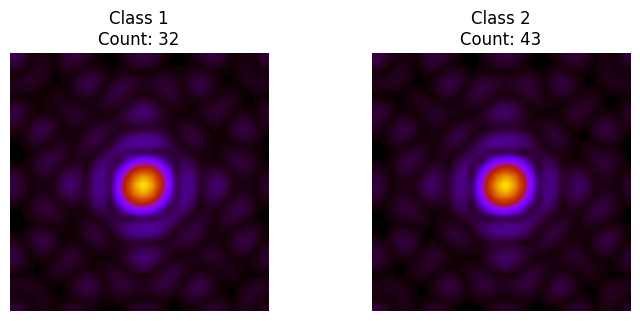

In [79]:
window_size = 32
n_components = 2
covariance = 'diag'
random_state = ti_random_state_choice
ti_ft_clf = mixture.GaussianMixture(
    n_components = n_components,
    covariance_type = covariance,
    random_state = random_state)
X_vec_Ti = mapped_array_ti.reshape(a, b*c)
ti_ft_classes = ti_ft_clf.fit_predict(X_vec_Ti) +1
ti_ft_cla = np.ndarray(shape=(
    np.amax(ti_ft_classes), int(window_size), int(window_size)))

rows = int(np.ceil(float(n_components)/5))
cols = int(np.ceil(float(np.amax(ti_ft_classes))/rows))
fig = plt.figure(figsize=(4*cols, 4*(1+rows//2)))
gs = gridspec.GridSpec(rows, cols)
print('\nGMM components')

ti_ft_cl_all = []
for i in range(np.amax(ti_ft_classes)):
    ti_ft_cl = mapped_array_ti[ti_ft_classes == i + 1]
    ti_ft_cl_all.append(ti_ft_cl)
    ti_ft_cla[i] = np.mean(ti_ft_cl, axis=0)
    ax = fig.add_subplot(gs[i])
    ax.imshow(ti_ft_cla[i, :, :], cmap='gnuplot',
            interpolation='Gaussian')
    ax.axis('off')
    ax.set_title('Class '+str(i+1)+'\nCount: '+str(len(ti_ft_cl)))

plt.subplots_adjust(hspace=0.6, wspace=0.4)
plt.show()

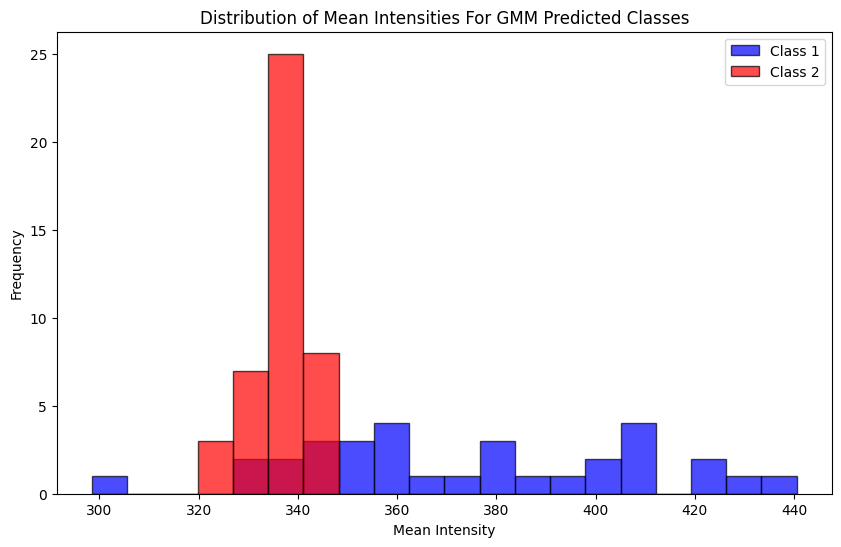

In [213]:
ti_class_labels = np.unique(ti_ft_classes)

ti_class_1_indices = np.where(ti_ft_classes == ti_class_labels[0])
ti_class_2_indices = np.where(ti_ft_classes == ti_class_labels[1])

ti_class_1_average_intensities = np.mean(mapped_array_ti[ti_class_1_indices], axis = (1,2))
ti_class_2_average_intensities = np.mean(mapped_array_ti[ti_class_2_indices], axis = (1,2))

ti_all_intensities = np.concatenate([ti_class_1_average_intensities, ti_class_2_average_intensities])
bins = np.histogram_bin_edges(ti_all_intensities, bins=20)

plt.figure(figsize=(10, 6))
plt.hist(ti_class_1_average_intensities, bins=bins, alpha=0.7, label='Class 1', color='blue', edgecolor='black')
plt.hist(ti_class_2_average_intensities, bins=bins, alpha=0.7, label='Class 2', color='red', edgecolor='black')
plt.title('Distribution of Mean Intensities For GMM Predicted Classes')
plt.xlabel('Mean Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

13.80558002655048
(32, 32)


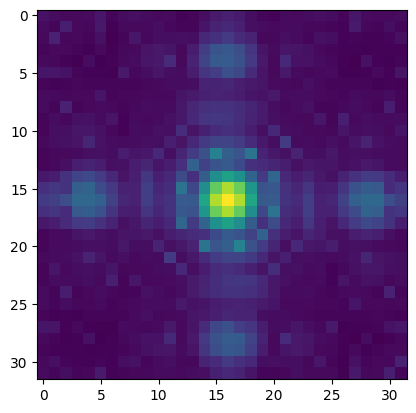

In [222]:
print(np.mean(np.std(mapped_array_ti[ti_class_2_indices], axis =0)))
print(np.std(mapped_array_ti[ti_class_2_indices], axis =0).shape)
plt.imshow(np.std(mapped_array_ti[ti_class_2_indices], axis=0))

In [226]:
from scipy import optimize
def gaussian(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-x)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-y)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

Text(0.95, 0.05, '\nx : 16.0\ny : 15.9\nwidth_x : 7.4\nwidth_y : 8.2')

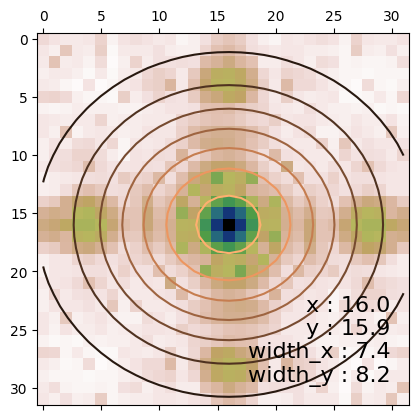

In [227]:
plt.matshow(np.std(mapped_array_ti[ti_class_2_indices], axis =0), cmap=plt.cm.gist_earth_r)
params = fitgaussian(np.std(mapped_array_ti[ti_class_2_indices], axis =0))
fit = gaussian(*params)

plt.contour(fit(*np.indices(np.std(mapped_array_ti[ti_class_2_indices], axis =0).shape)), cmap=plt.cm.copper)
ax = plt.gca()
(height, x, y, width_x, width_y) = params
plt.text(0.95, 0.05, """
x : %.1f
y : %.1f
width_x : %.1f
width_y : %.1f""" %(x, y, width_x, width_y),
        fontsize=16, horizontalalignment='right',
        verticalalignment='bottom', transform=ax.transAxes)

Text(0.95, 0.05, '\nx : 16.0\ny : 16.0\nwidth_x : 4.1\nwidth_y : 3.9')

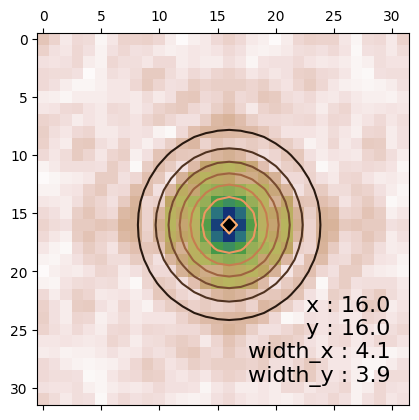

In [228]:
plt.matshow(np.std(mapped_array_ti[ti_class_1_indices], axis =0), cmap=plt.cm.gist_earth_r)
params = fitgaussian(np.std(mapped_array_ti[ti_class_1_indices], axis =0))
fit = gaussian(*params)

plt.contour(fit(*np.indices(np.std(mapped_array_ti[ti_class_1_indices], axis =0).shape)), cmap=plt.cm.copper)
ax = plt.gca()
(height, x, y, width_x, width_y) = params
plt.text(0.95, 0.05, """
x : %.1f
y : %.1f
width_x : %.1f
width_y : %.1f""" %(x, y, width_x, width_y),
        fontsize=16, horizontalalignment='right',
        verticalalignment='bottom', transform=ax.transAxes)

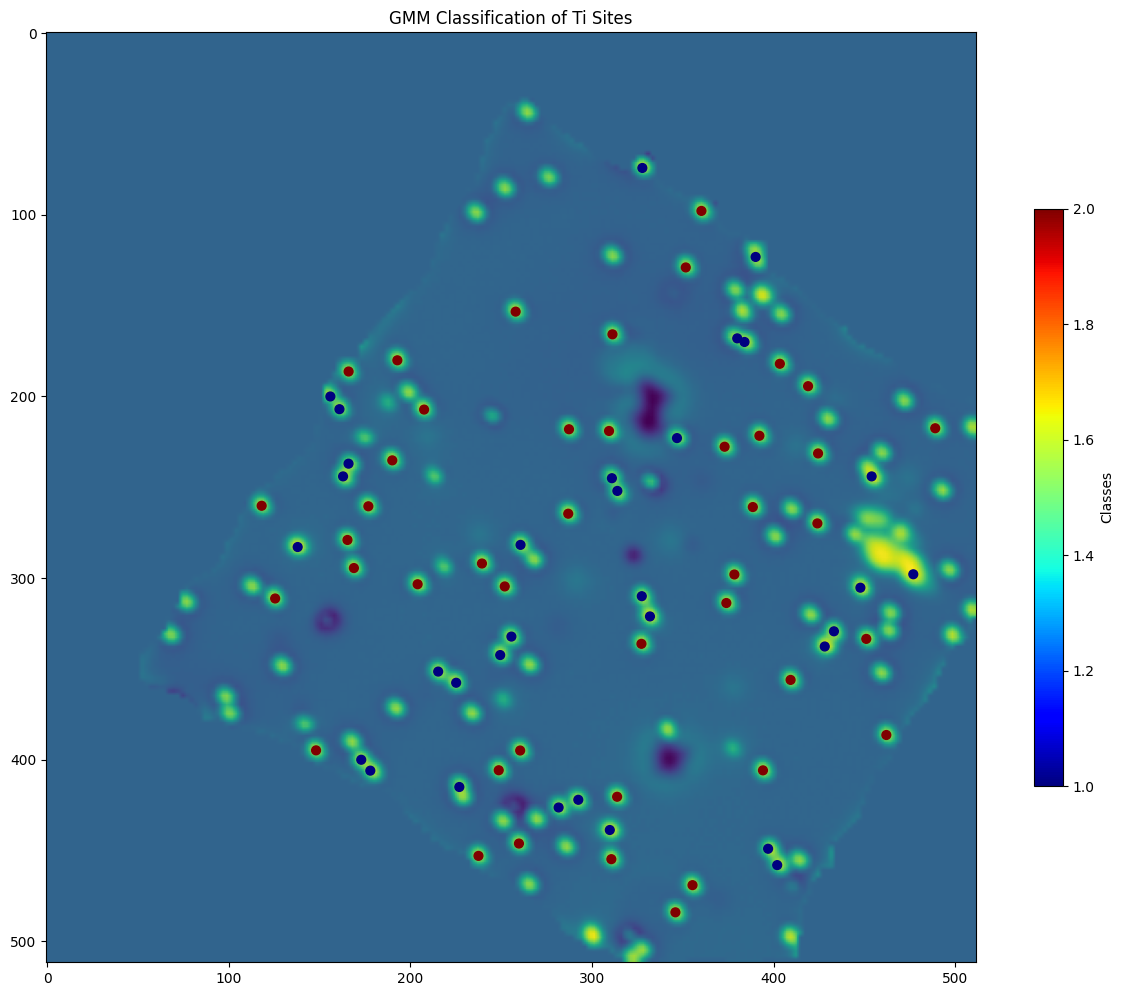

In [81]:
plt.figure(figsize=(15, 15))
sc = plt.scatter(Ti_coordinates[:, 0], Ti_coordinates[:, 1], c=ti_ft_classes, s=40,
            cmap="jet")
im = plt.imshow(expdata)
cbar = plt.colorbar(sc, shrink=0.5, label="Classes")
plt.title('GMM Classification of Ti Sites')
plt.show()

Text(0, 0.5, 'explained variance (percent)')

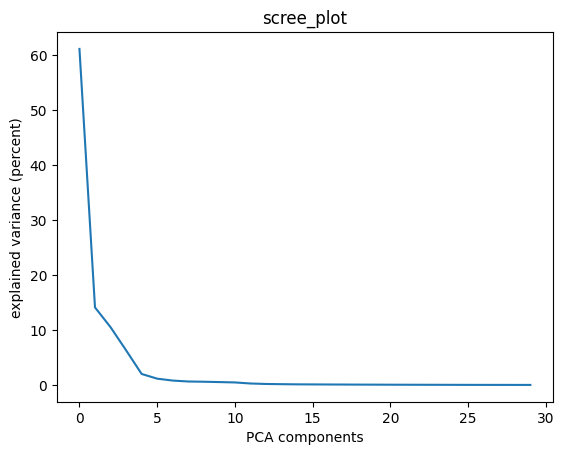

In [82]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 30)
pca_load = pca.fit_transform(X_vec_Ti)
pca_components = pca.components_

plt.plot(np.arange(30), pca.explained_variance_ratio_*100)
plt.title('scree_plot')
plt.xlabel('PCA components')
plt.ylabel('explained variance (percent)')

Loading Maps


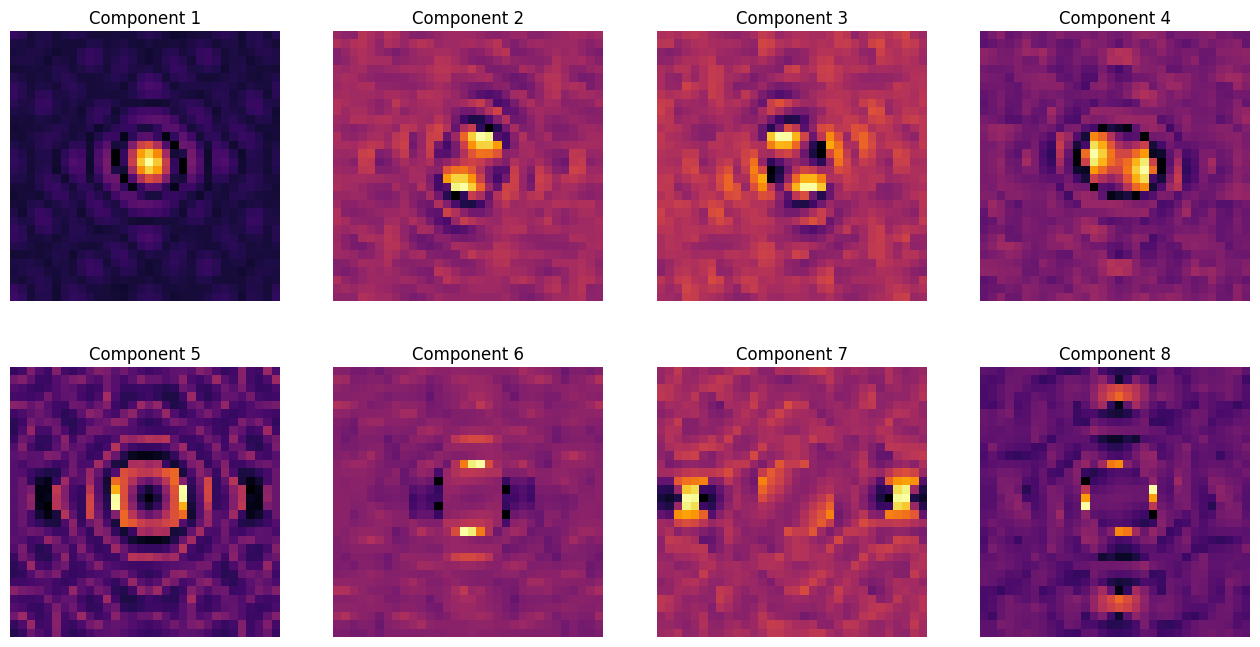

In [83]:
print('Loading Maps')
rows, cols = 2, 4
gs2 = gridspec.GridSpec(rows, cols)
fig2 = plt.figure(figsize = (4*cols, 4*(1+rows//1.5)))
for i in range(8):
    ax2 = fig2.add_subplot(gs2[i])
    ax2.imshow(pca_components[i,:].reshape(window_size, window_size), cmap = 'inferno', origin = 'lower')
    ax2.set_title('Component ' + str(i+1))
    plt.tick_params(labelsize = 18)
    plt.axis('off')
plt.show()

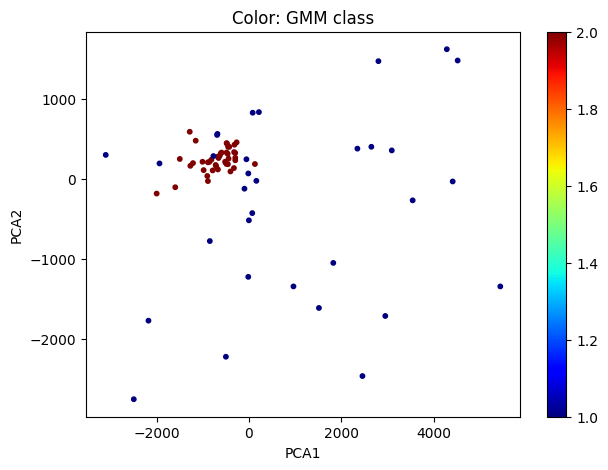

In [84]:
fig, ax = plt.subplots(figsize = (7,5))
scatter_plot = ax.scatter(pca_load[:,0], pca_load[:,1], c = ti_ft_classes, cmap = 'jet', s = 10)
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_title('Color: GMM class')
plt.colorbar(scatter_plot, ax=ax)

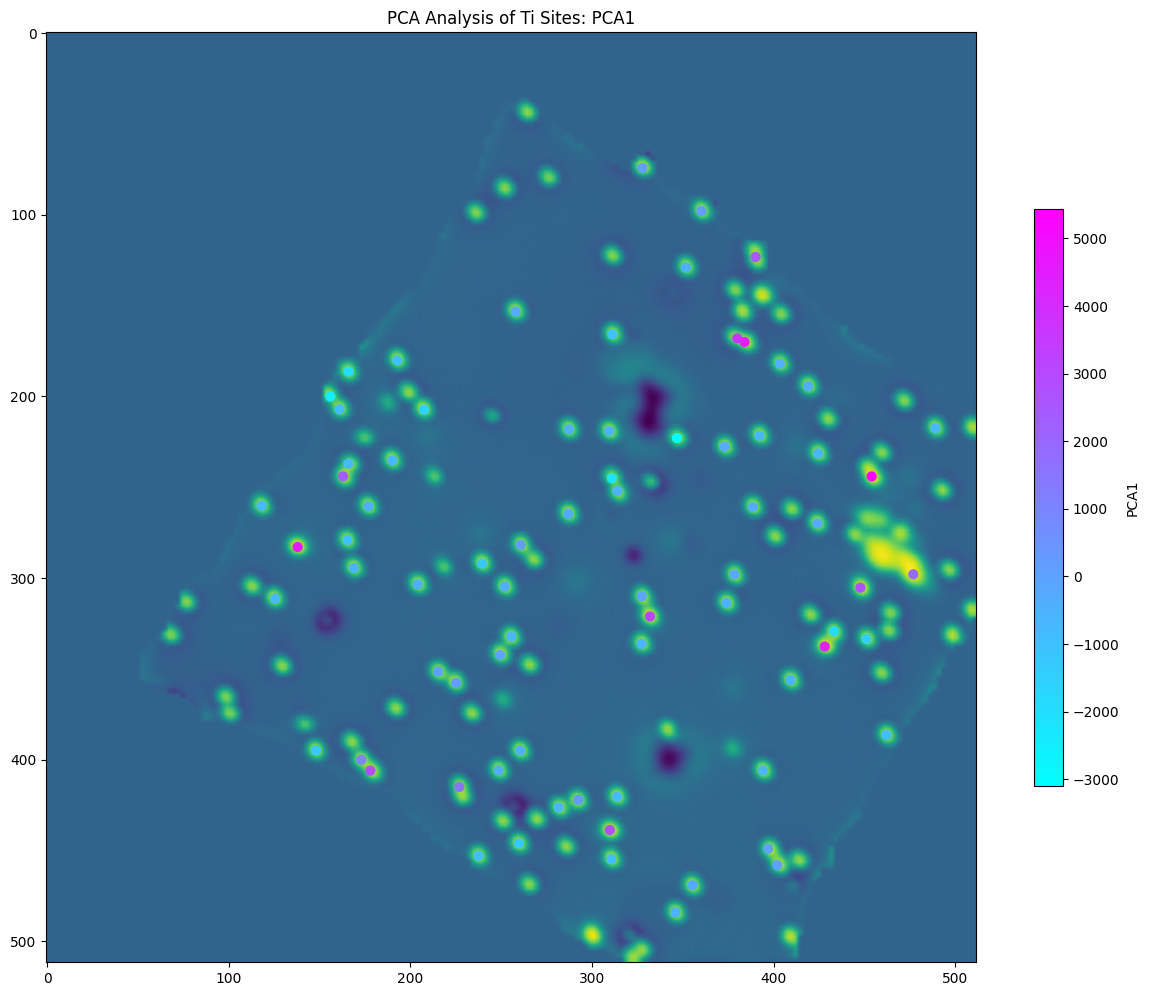

In [85]:
plt.figure(figsize=(15, 15))
sc = plt.scatter(Ti_coordinates[:, 0], Ti_coordinates[:, 1], c=pca_load[:,0], s=40,
            cmap="cool")
im = plt.imshow(expdata)
cbar = plt.colorbar(sc, shrink=0.5, label="PCA1")
plt.title("PCA Analysis of Ti Sites: PCA1")
plt.show()

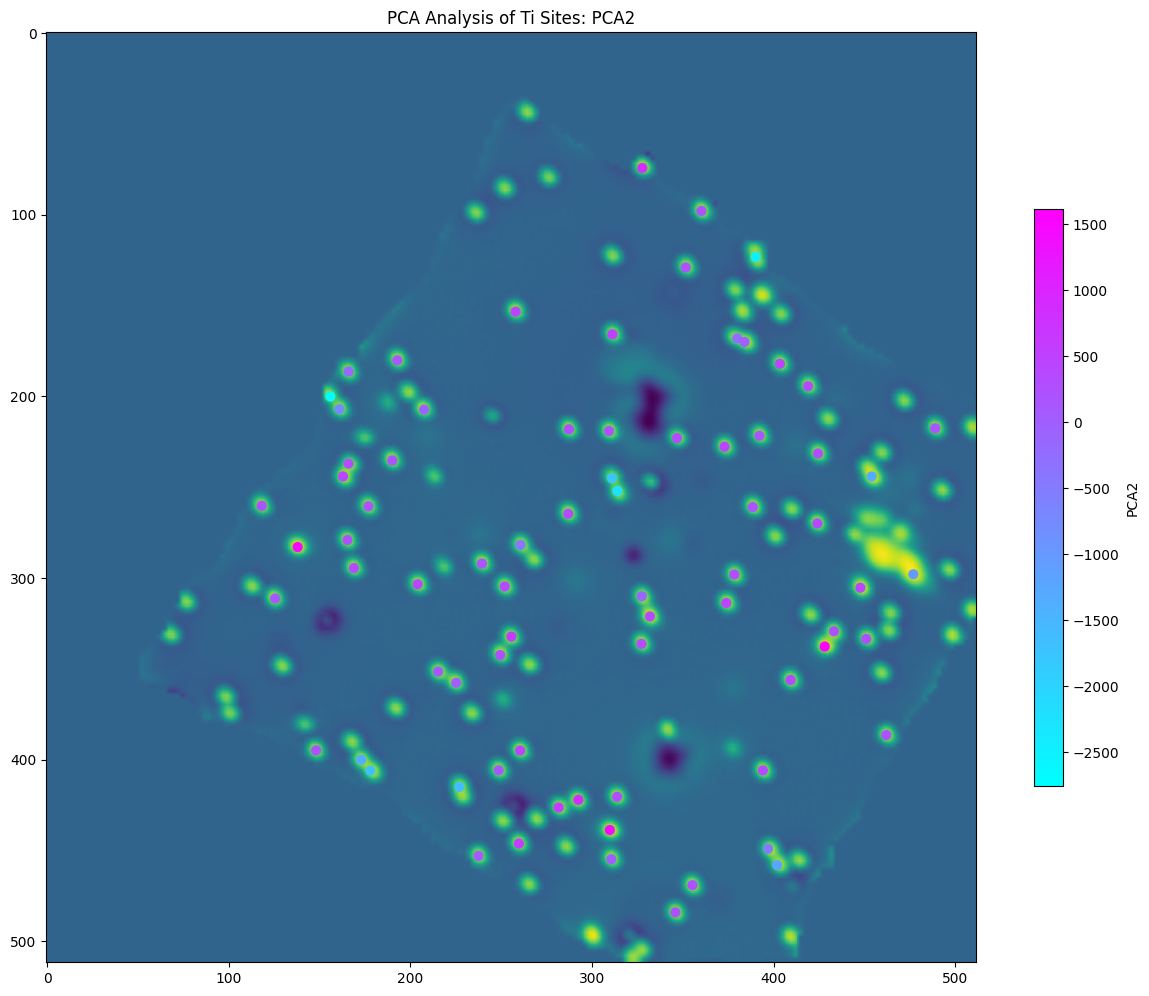

In [86]:
plt.figure(figsize=(15, 15))
sc = plt.scatter(Ti_coordinates[:, 0], Ti_coordinates[:, 1], c=pca_load[:,1], s=40,
            cmap="cool")
im = plt.imshow(expdata)
cbar = plt.colorbar(sc, shrink=0.5, label="PCA2")
plt.title("PCA Analysis of Ti Sites: PCA2")
plt.show()

In [87]:
# Training the rVAE with tuned parameters on the subimages generated 
in_dim = (window_size, window_size)   # Input dimensions of the dataset

rvae_mgo = aoi.models.rVAE(in_dim, nb_classes=2,
                           numhidden_encoder = 512, numhidden_decoder = 512, skip = True)

rvae_mgo.fit(training_data, class_numeric, training_cycles=100, batch_size=5)

Epoch: 1/100, Training loss: 337713.1462
Epoch: 2/100, Training loss: 329601.6544
Epoch: 3/100, Training loss: 326734.5706
Epoch: 4/100, Training loss: 320644.9488
Epoch: 5/100, Training loss: 309918.0575
Epoch: 6/100, Training loss: 296490.9519
Epoch: 7/100, Training loss: 282510.8456
Epoch: 8/100, Training loss: 268305.3725
Epoch: 9/100, Training loss: 253423.7950
Epoch: 10/100, Training loss: 237784.5650
Epoch: 11/100, Training loss: 221002.1125
Epoch: 12/100, Training loss: 204082.4919
Epoch: 13/100, Training loss: 186975.7875
Epoch: 14/100, Training loss: 169796.7578
Epoch: 15/100, Training loss: 153004.8138
Epoch: 16/100, Training loss: 136846.7564
Epoch: 17/100, Training loss: 122496.3475
Epoch: 18/100, Training loss: 109670.4275
Epoch: 19/100, Training loss: 98381.2853
Epoch: 20/100, Training loss: 87505.5442
Epoch: 21/100, Training loss: 78223.6275
Epoch: 22/100, Training loss: 70908.4252
Epoch: 23/100, Training loss: 64097.4781
Epoch: 24/100, Training loss: 58699.5484
Epoch: 

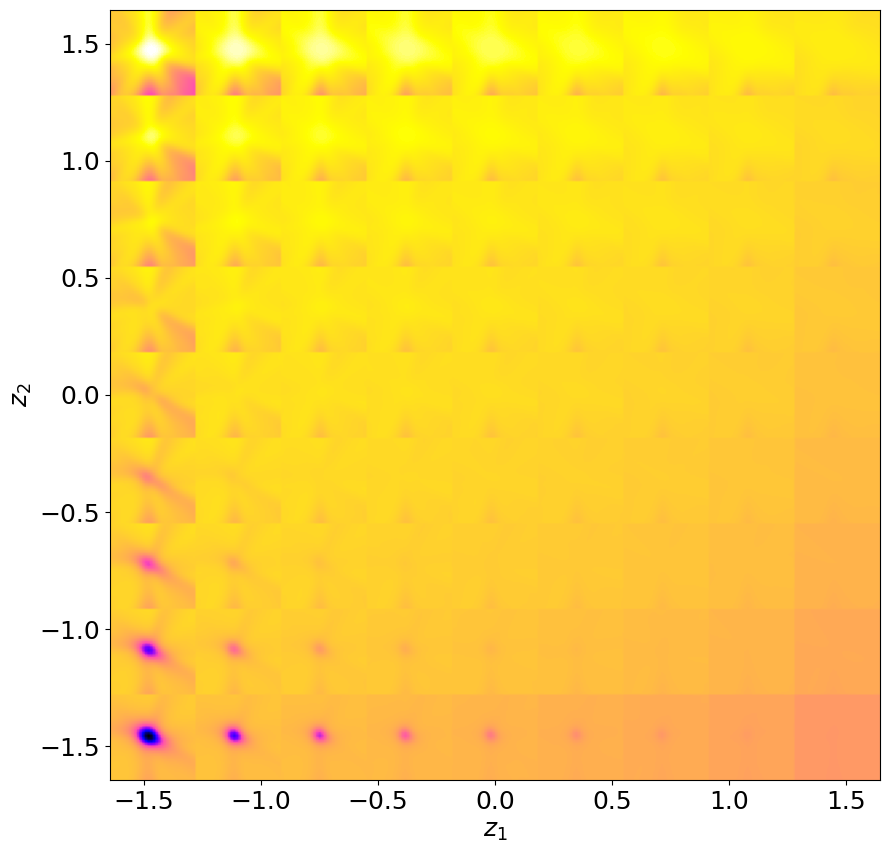

array([[58.37932587, 58.2419014 , 58.27285385, ..., 60.75819016,
        60.76429367, 60.75954056],
       [58.44439697, 58.32363892, 58.2537117 , ..., 60.80255508,
        60.79849625, 60.78189087],
       [58.43098831, 58.36976242, 58.30116272, ..., 60.8511467 ,
        60.83440018, 60.80662918],
       ...,
       [57.85393524, 57.85907364, 57.86849976, ..., 52.44679642,
        52.44207001, 52.43716812],
       [57.78833008, 57.81693268, 57.8475914 , ..., 52.44515991,
        52.44085693, 52.43553925],
       [57.74269485, 57.79644394, 57.84379196, ..., 52.44265366,
        52.4394722 , 52.43467331]])

In [88]:
rvae_mgo.manifold2d(label=1, origin="upper", cmap="gnuplot2")

In [89]:
z_mean, z_sd = rvae_mgo.encode(training_data)   # Encoding the full input dataset

z1, z2, z3 = z_mean[:,0], z_mean[:, 1:3], z_mean[:, 3:]

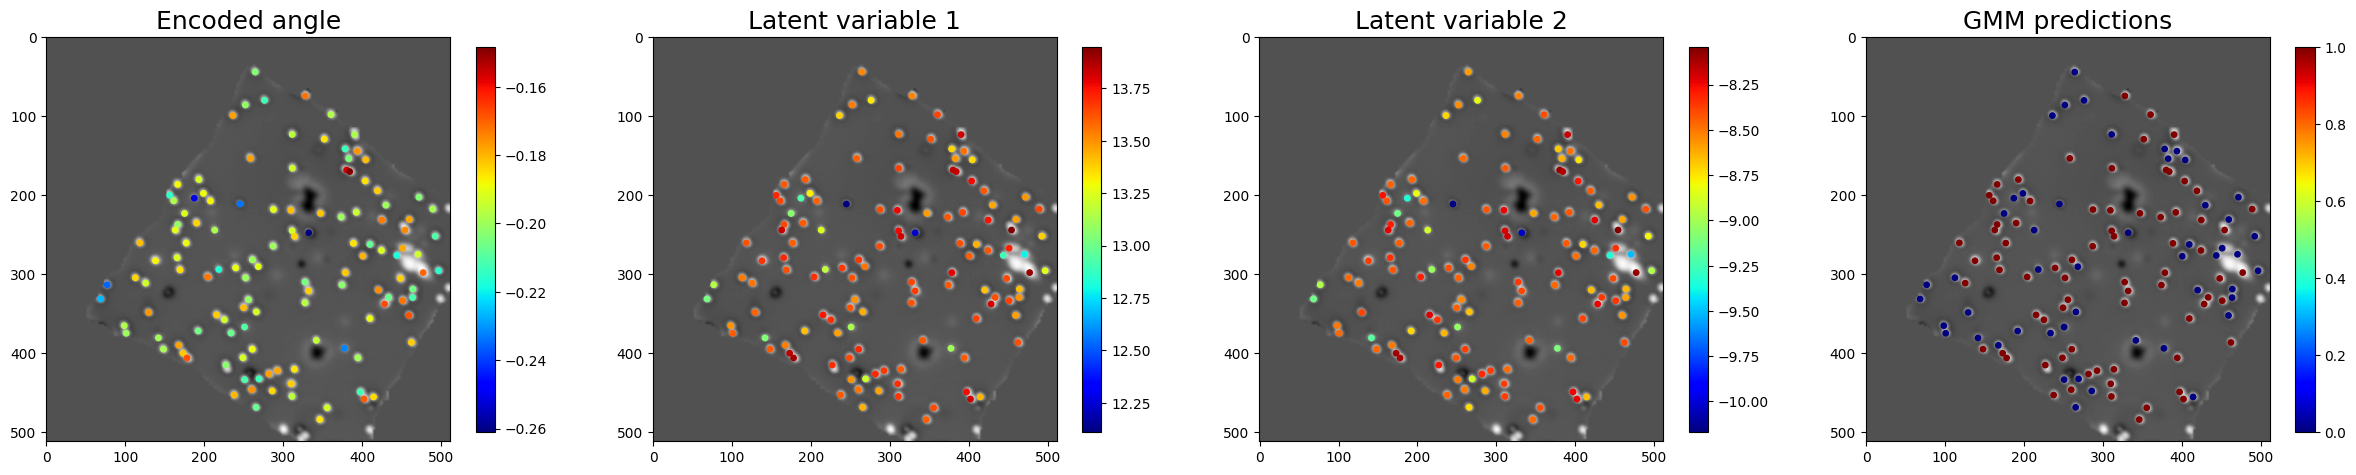

In [90]:
fig, ax = plt.subplots(1, 4, figsize=(30, 10))
im0 = ax[0].imshow(expdata, cmap="gray")
sc0 = ax[0].scatter(training_coordinates[:, 0], training_coordinates[:, 1], c=z1, s=15,
                cmap="jet")
ax[0].set_title("Encoded angle", fontsize=18)
fig.colorbar(sc0, ax=ax[0], shrink=.5)

im1 = ax[1].imshow(expdata, cmap="gray")
sc1 = ax[1].scatter(training_coordinates[:, 0], training_coordinates[:, 1], c=z3[:,0], s=15,
                cmap="jet")
ax[1].set_title("Latent variable 1", fontsize=18)
fig.colorbar(sc1, ax=ax[1], shrink=.5)

im2 = ax[2].imshow(expdata, cmap="gray")
sc2 = ax[2].scatter(training_coordinates[:, 0], training_coordinates[:, 1], c=z3[:,1], s=15,
                cmap="jet")
ax[2].set_title("Latent variable 2", fontsize=18)
fig.colorbar(sc2, ax=ax[2], shrink=.5)

im3 = ax[3].imshow(expdata, cmap="gray")
sc3 = ax[3].scatter(training_coordinates[:, 0], training_coordinates[:, 1], c=class_numeric, s=15,
                cmap="jet")
ax[3].set_title("GMM predictions", fontsize=18)
fig.colorbar(sc3, ax=ax[3], shrink=.5)

plt.show()

In [91]:
z_mean_Fe, z_sd_Fe = rvae_mgo.encode(Fe_data)   # Encoding the full input dataset

z1_Fe, z2_Fe, z3_Fe = z_mean_Fe[:,0], z_mean_Fe[:, 1:3], z_mean_Fe[:, 3:]

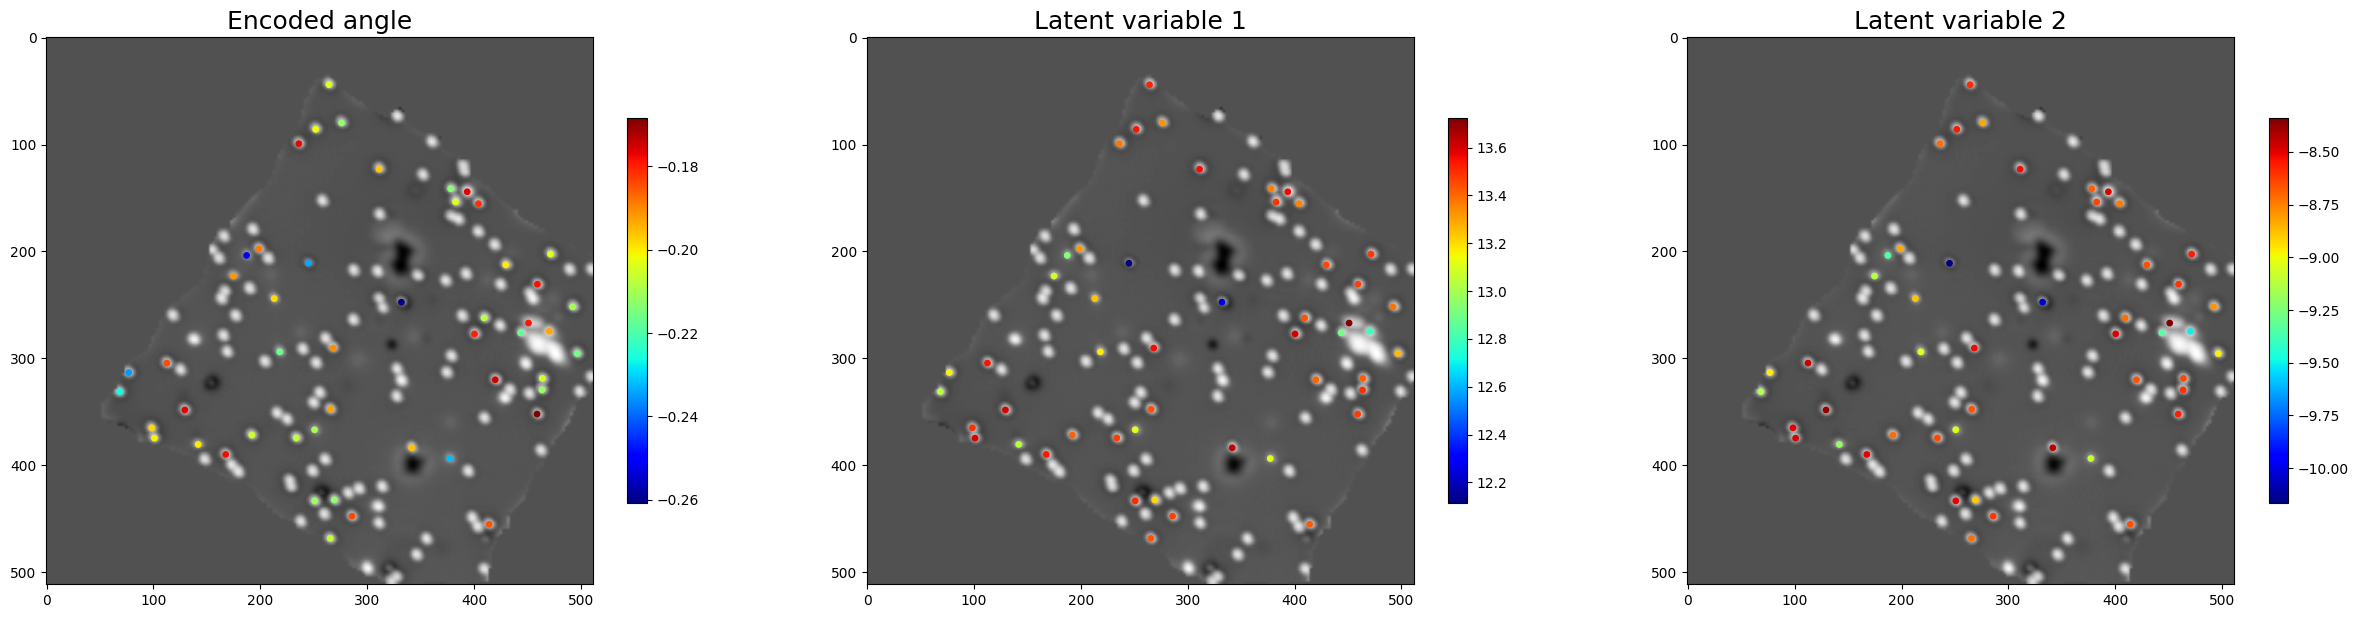

In [92]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10))
im0 = ax[0].imshow(expdata, cmap="gray")
sc0 = ax[0].scatter(Fe_coordinates[:, 0], Fe_coordinates[:, 1], c=z1_Fe, s=15,
                cmap="jet")
ax[0].set_title("Encoded angle", fontsize=18)
fig.colorbar(sc0, ax=ax[0], shrink=.5)

im1 = ax[1].imshow(expdata, cmap="gray")
sc1 = ax[1].scatter(Fe_coordinates[:, 0], Fe_coordinates[:, 1], c=z3_Fe[:,0], s=15,
                cmap="jet")
ax[1].set_title("Latent variable 1", fontsize=18)
fig.colorbar(sc1, ax=ax[1], shrink=.5)

im2 = ax[2].imshow(expdata, cmap="gray")
sc2 = ax[2].scatter(Fe_coordinates[:, 0], Fe_coordinates[:, 1], c=z3_Fe[:,1], s=15,
                cmap="jet")
ax[2].set_title("Latent variable 2", fontsize=18)
fig.colorbar(sc2, ax=ax[2], shrink=.5)

plt.show()

Text(0.5, 1.0, 'Latent space')

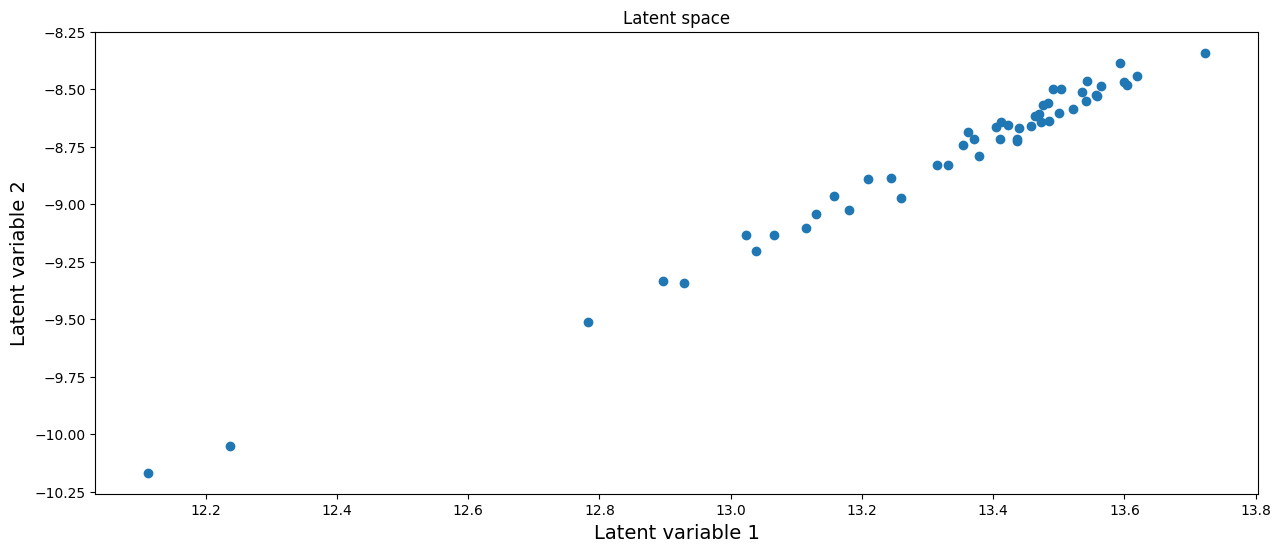

In [93]:
fig, (ax1) = plt.subplots(1, 1, figsize =(15, 6))
im1 = ax1.scatter(z3_Fe[:,0],z3_Fe[:,1])
ax1.set_xlabel("Latent variable 1", fontsize=14)
ax1.set_ylabel("Latent variable 2", fontsize=14)
ax1.set_title('Latent space')

In [94]:
pixel_values = []
mean_intensity = []
min_intensity = []
max_intensity = []

for i, data in enumerate(Fe_data):
    
    pixel_values.append(Fe_data[i][16][16])
    mean_intensity.append(np.mean(data))

    min_intensity.append(np.min(data))
    max_intensity.append(np.max(data))

In [95]:
from scipy.spatial import distance_matrix

nearest_neighbour = []
n_nearest_neighbours = []

Fe_indices = np.where(class_numeric == 0)[0]

dist_matrix = distance_matrix(training_coordinates,training_coordinates)
np.fill_diagonal(dist_matrix, np.inf)
dist_matrix = dist_matrix[Fe_indices, :]
nearest_indices = np.argmin(dist_matrix, axis=1)
for j, index in enumerate(nearest_indices):
    nearest_neighbour.append(dist_matrix[j][index])
for j in range (len(dist_matrix)):
    n = 0
    for k in dist_matrix[j]:
        if k<12:
            n = n+1
    n_nearest_neighbours.append(n)

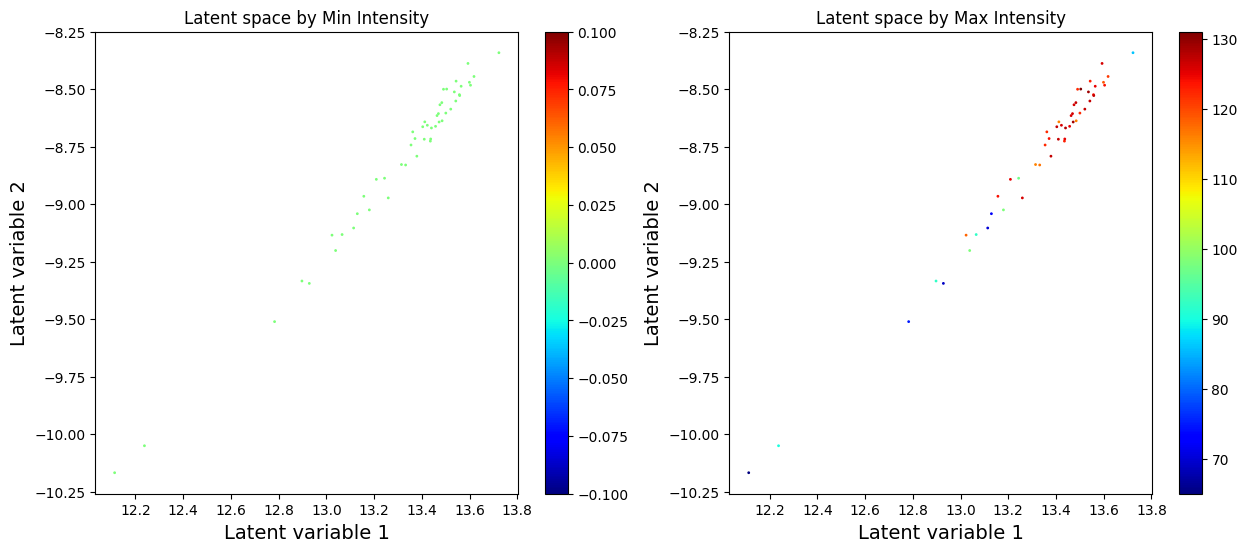

In [96]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 6))
im1 = ax1.scatter(z3_Fe[:,0],z3_Fe[:,1], c = np.array(min_intensity), s=1, cmap='jet')
ax1.set_xlabel("Latent variable 1", fontsize=14)
ax1.set_ylabel("Latent variable 2", fontsize=14)
ax1.set_title('Latent space by Min Intensity')
fig.colorbar(im1, ax=ax1)

im2 = ax2.scatter(z3_Fe[:,0],z3_Fe[:,1], c = np.array(max_intensity), s=1, cmap='jet')
ax2.set_xlabel("Latent variable 1", fontsize=14)
ax2.set_ylabel("Latent variable 2", fontsize=14)
ax2.set_title('Latent space by Max Intensity')
fig.colorbar(im2, ax=ax2)

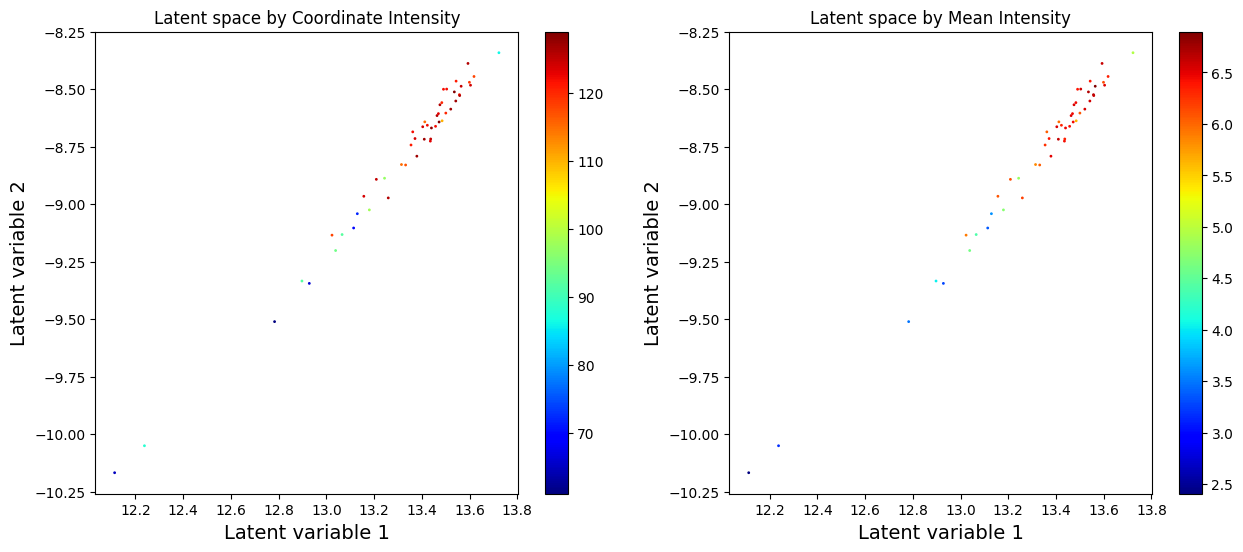

In [97]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 6))
im1 = ax1.scatter(z3_Fe[:,0],z3_Fe[:,1], c = np.array(pixel_values), s=1, cmap='jet')
ax1.set_xlabel("Latent variable 1", fontsize=14)
ax1.set_ylabel("Latent variable 2", fontsize=14)
ax1.set_title('Latent space by Coordinate Intensity')
fig.colorbar(im1, ax=ax1)

im2 = ax2.scatter(z3_Fe[:,0],z3_Fe[:,1], c = np.array(mean_intensity), s=1, cmap='jet')
ax2.set_xlabel("Latent variable 1", fontsize=14)
ax2.set_ylabel("Latent variable 2", fontsize=14)
ax2.set_title('Latent space by Mean Intensity')
fig.colorbar(im2, ax=ax2)

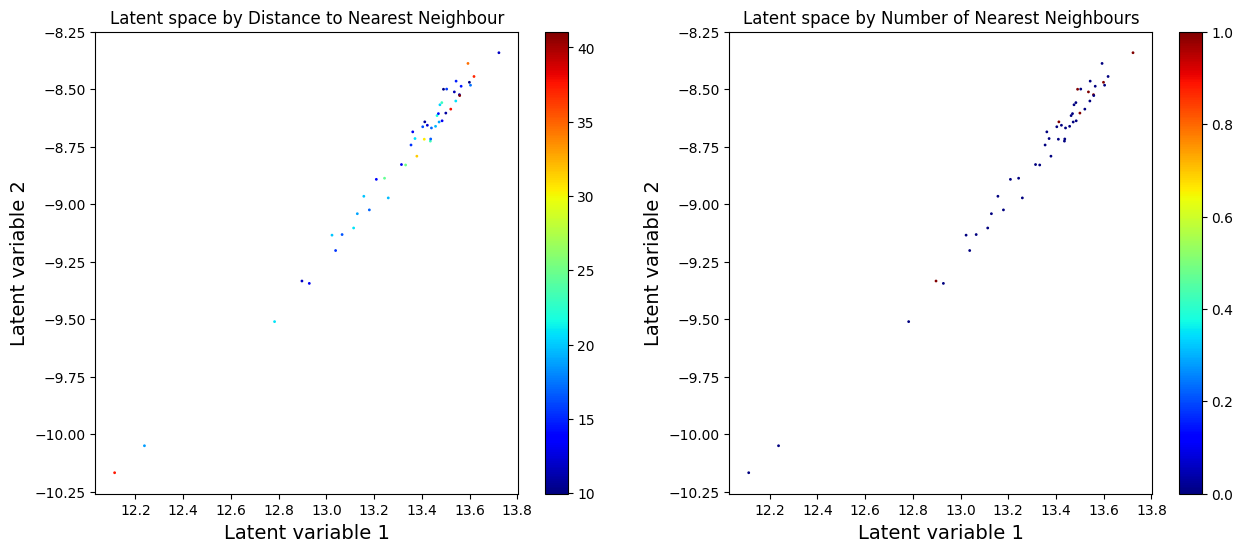

In [98]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 6))
im1 = ax1.scatter(z3_Fe[:,0],z3_Fe[:,1], c = np.array(nearest_neighbour), s=1, cmap='jet')
ax1.set_xlabel("Latent variable 1", fontsize=14)
ax1.set_ylabel("Latent variable 2", fontsize=14)
ax1.set_title('Latent space by Distance to Nearest Neighbour')
fig.colorbar(im1, ax=ax1)

im2 = ax2.scatter(z3_Fe[:,0],z3_Fe[:,1], c = np.array(n_nearest_neighbours), s=1, cmap='jet')
ax2.set_xlabel("Latent variable 1", fontsize=14)
ax2.set_ylabel("Latent variable 2", fontsize=14)
ax2.set_title('Latent space by Number of Nearest Neighbours')
fig.colorbar(im2, ax=ax2)

In [99]:
z_mean_Ti, z_sd_Ti = rvae_mgo.encode(Ti_data)   # Encoding the full input dataset

z1_Ti, z2_Ti, z3_Ti = z_mean_Ti[:,0], z_mean_Ti[:, 1:3], z_mean_Ti[:, 3:]

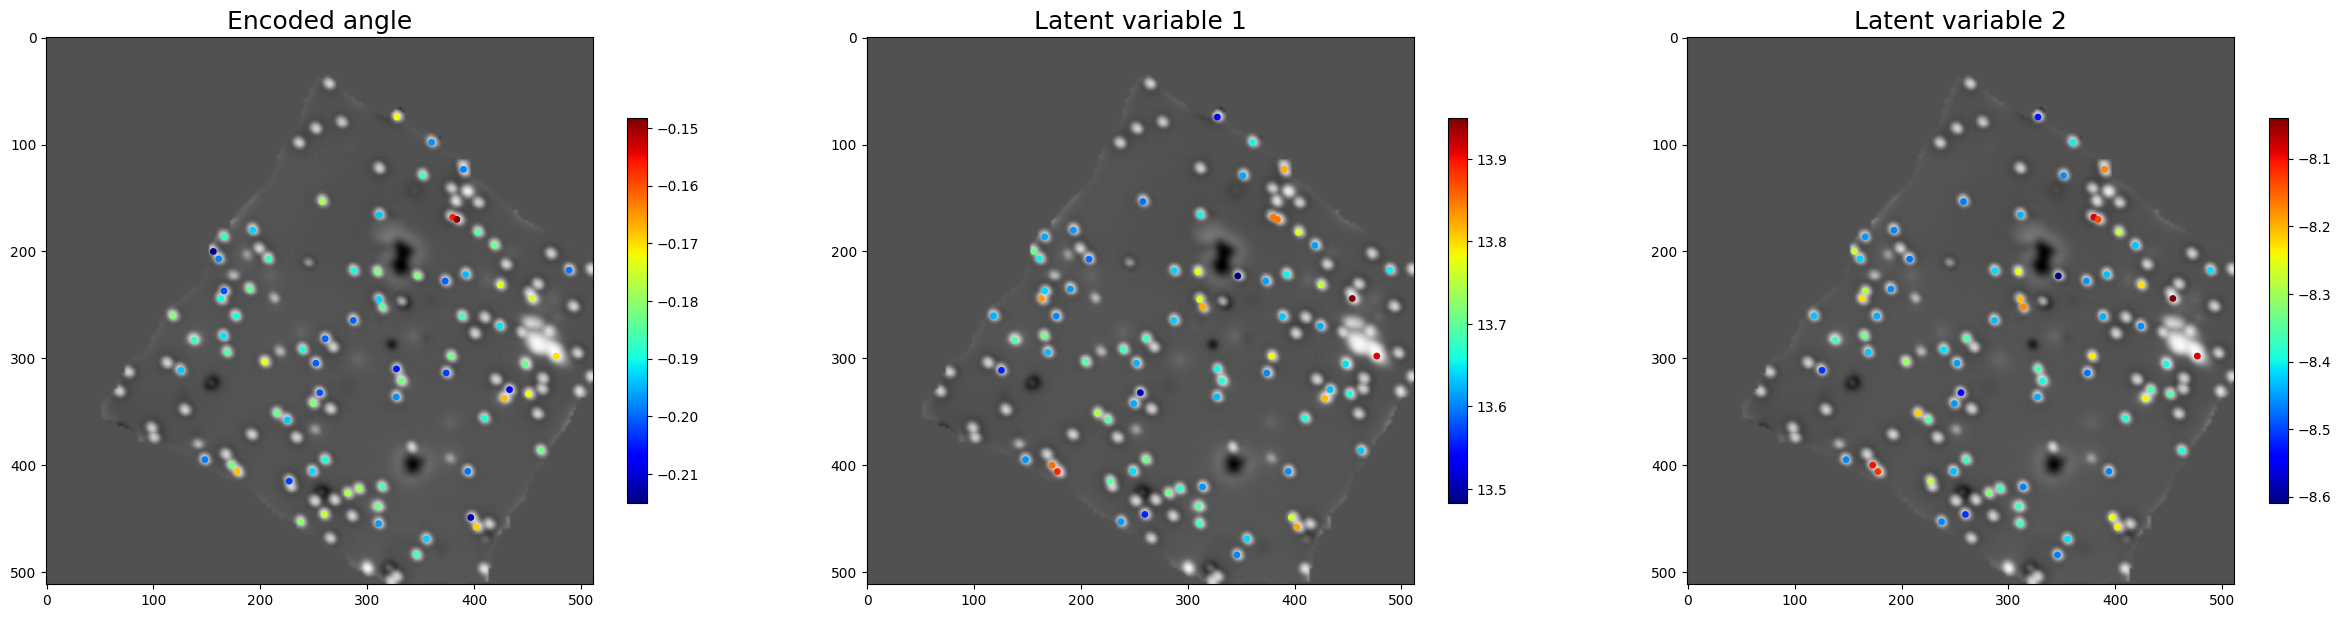

In [100]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10))
im0 = ax[0].imshow(expdata, cmap="gray")
sc0 = ax[0].scatter(Ti_coordinates[:, 0], Ti_coordinates[:, 1], c=z1_Ti, s=15,
                cmap="jet")
ax[0].set_title("Encoded angle", fontsize=18)
fig.colorbar(sc0, ax=ax[0], shrink=.5)

im1 = ax[1].imshow(expdata, cmap="gray")
sc1 = ax[1].scatter(Ti_coordinates[:, 0], Ti_coordinates[:, 1], c=z3_Ti[:,0], s=15,
                cmap="jet")
ax[1].set_title("Latent variable 1", fontsize=18)
fig.colorbar(sc1, ax=ax[1], shrink=.5)

im2 = ax[2].imshow(expdata, cmap="gray")
sc2 = ax[2].scatter(Ti_coordinates[:, 0], Ti_coordinates[:, 1], c=z3_Ti[:,1], s=15,
                cmap="jet")
ax[2].set_title("Latent variable 2", fontsize=18)
fig.colorbar(sc2, ax=ax[2], shrink=.5)

plt.show()

Text(0.5, 1.0, 'Latent space')

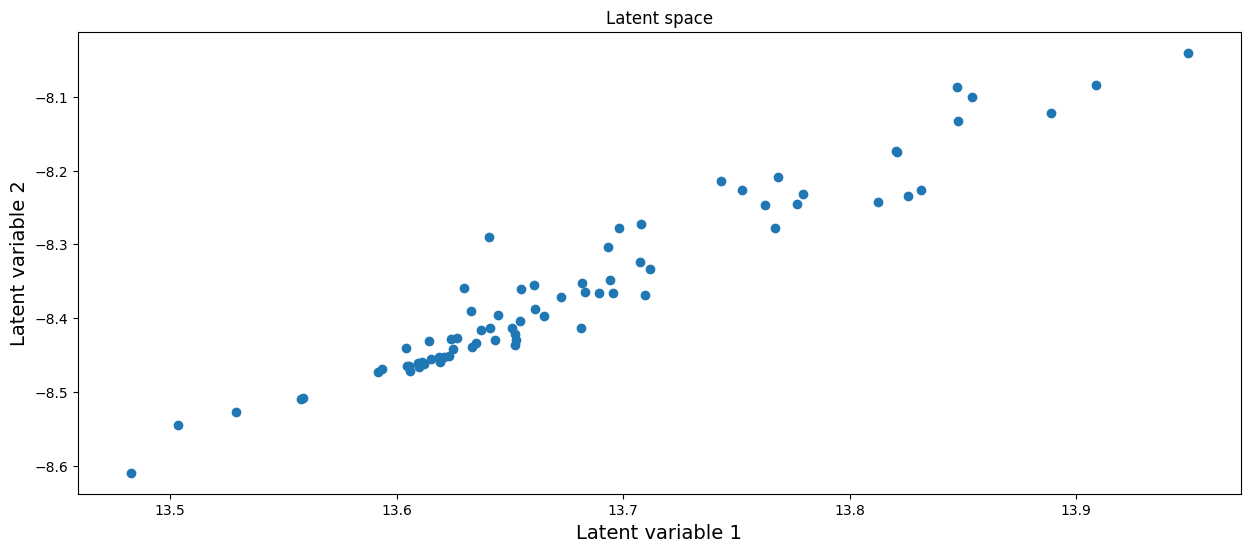

In [101]:
fig, (ax1) = plt.subplots(1, 1, figsize =(15, 6))
im1 = ax1.scatter(z3_Ti[:,0],z3_Ti[:,1])
ax1.set_xlabel("Latent variable 1", fontsize=14)
ax1.set_ylabel("Latent variable 2", fontsize=14)
ax1.set_title('Latent space')

In [102]:
pixel_values = []
mean_intensity = []
min_intensity = []
max_intensity = []

for i, data in enumerate(Ti_data):
    
    pixel_values.append(Ti_data[i][16][16])
    mean_intensity.append(np.mean(data))

    min_intensity.append(np.min(data))
    max_intensity.append(np.max(data))

In [103]:
from scipy.spatial import distance_matrix

nearest_neighbour = []
n_nearest_neighbours = []

Ti_indices = np.where(class_numeric == 1)[0]

dist_matrix = distance_matrix(training_coordinates,training_coordinates)
np.fill_diagonal(dist_matrix, np.inf)
dist_matrix = dist_matrix[Ti_indices, :]
nearest_indices = np.argmin(dist_matrix, axis=1)
for j, index in enumerate(nearest_indices):
    nearest_neighbour.append(dist_matrix[j][index])
for j in range (len(dist_matrix)):
    n = 0
    for k in dist_matrix[j]:
        if k<12:
            n = n+1
    n_nearest_neighbours.append(n)

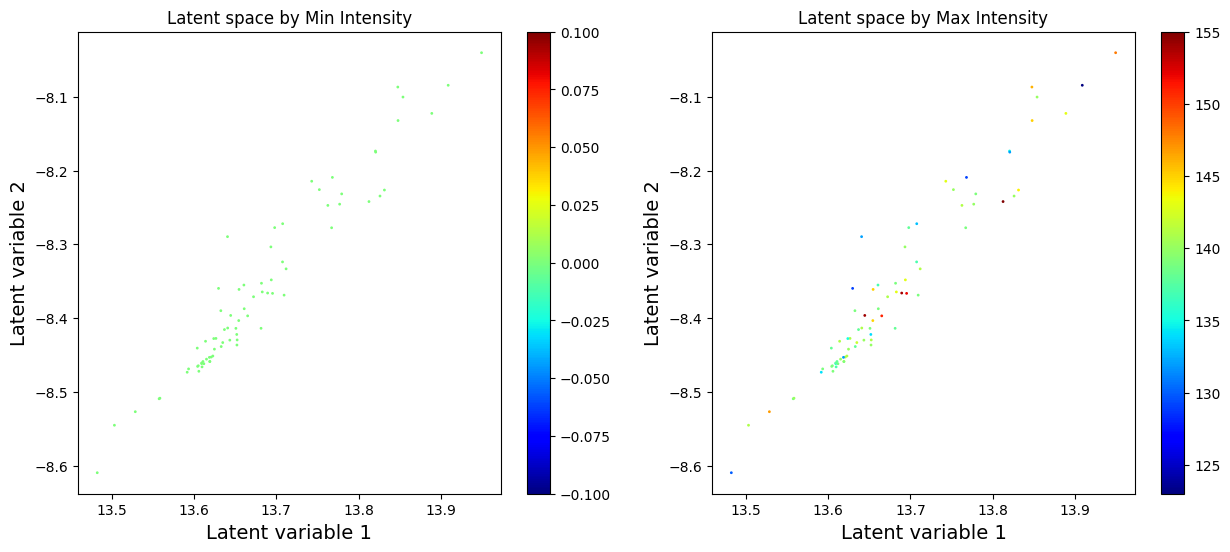

In [104]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 6))
im1 = ax1.scatter(z3_Ti[:,0],z3_Ti[:,1], c = np.array(min_intensity), s=1, cmap='jet')
ax1.set_xlabel("Latent variable 1", fontsize=14)
ax1.set_ylabel("Latent variable 2", fontsize=14)
ax1.set_title('Latent space by Min Intensity')
fig.colorbar(im1, ax=ax1)

im2 = ax2.scatter(z3_Ti[:,0],z3_Ti[:,1], c = np.array(max_intensity), s=1, cmap='jet')
ax2.set_xlabel("Latent variable 1", fontsize=14)
ax2.set_ylabel("Latent variable 2", fontsize=14)
ax2.set_title('Latent space by Max Intensity')
fig.colorbar(im2, ax=ax2)

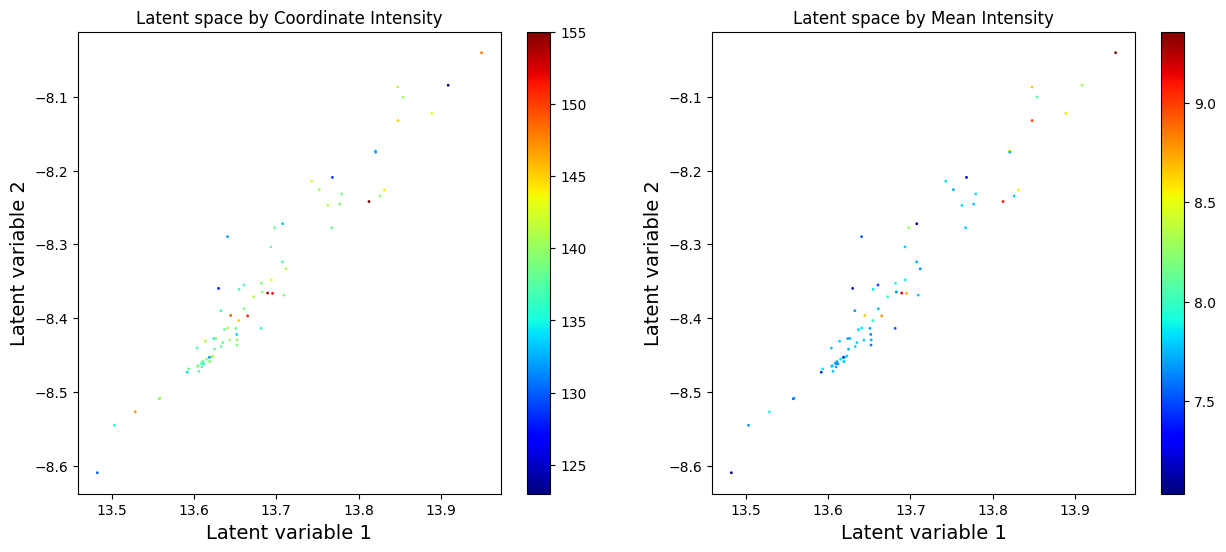

In [105]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 6))
im1 = ax1.scatter(z3_Ti[:,0],z3_Ti[:,1], c = np.array(pixel_values), s=1, cmap='jet')
ax1.set_xlabel("Latent variable 1", fontsize=14)
ax1.set_ylabel("Latent variable 2", fontsize=14)
ax1.set_title('Latent space by Coordinate Intensity')
fig.colorbar(im1, ax=ax1)

im2 = ax2.scatter(z3_Ti[:,0],z3_Ti[:,1], c = np.array(mean_intensity), s=1, cmap='jet')
ax2.set_xlabel("Latent variable 1", fontsize=14)
ax2.set_ylabel("Latent variable 2", fontsize=14)
ax2.set_title('Latent space by Mean Intensity')
fig.colorbar(im2, ax=ax2)

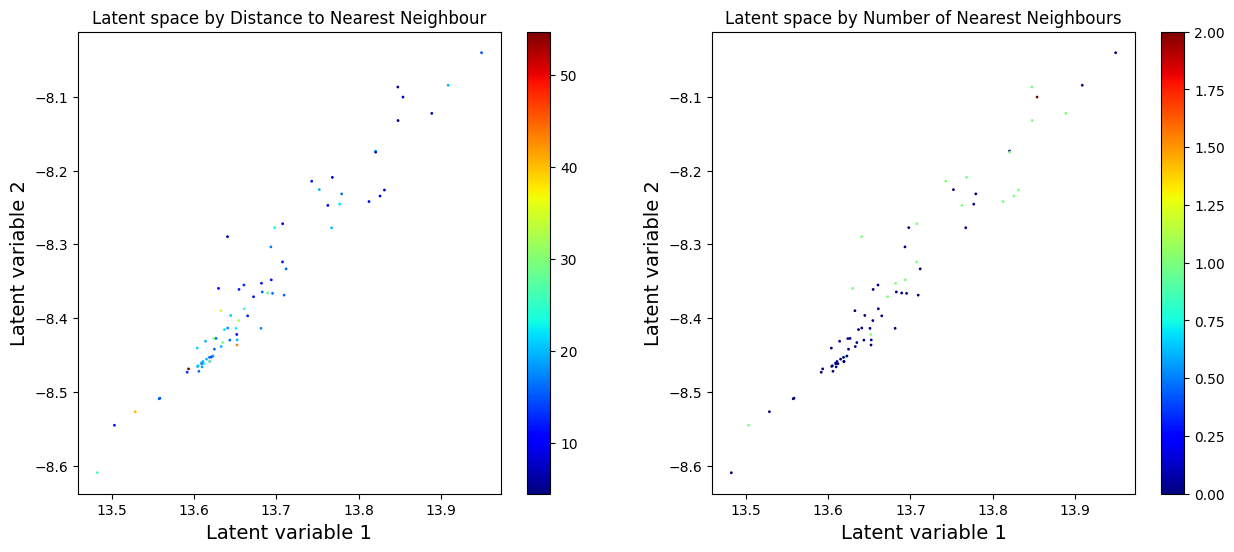

In [106]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 6))
im1 = ax1.scatter(z3_Ti[:,0],z3_Ti[:,1], c = np.array(nearest_neighbour), s=1, cmap='jet')
ax1.set_xlabel("Latent variable 1", fontsize=14)
ax1.set_ylabel("Latent variable 2", fontsize=14)
ax1.set_title('Latent space by Distance to Nearest Neighbour')
fig.colorbar(im1, ax=ax1)

im2 = ax2.scatter(z3_Ti[:,0],z3_Ti[:,1], c = np.array(n_nearest_neighbours), s=1, cmap='jet')
ax2.set_xlabel("Latent variable 1", fontsize=14)
ax2.set_ylabel("Latent variable 2", fontsize=14)
ax2.set_title('Latent space by Number of Nearest Neighbours')
fig.colorbar(im2, ax=ax2)

## 